# Methodology for the optimized localization of charging infrastructure for electric vehicles in urban environments

This program code is part of Jan Lehmann's master's thesis and is used for the localization of charging infrastructure in urban areas. It can be applied to different cities and further refined with the help of various input data. Further information and instructions for use can be found in the master's thesis.

To adapt the methodology to a specific city go to the next chapter (Data).

## Functions

### Imported functions and general settings

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import shapely
import os
import time
from scipy.ndimage import convolve
from collections import Counter
from geopy.distance import geodesic

In [7]:
pd.set_option('display.max_rows', 220)

### Other functions

In [9]:
def create_grid(gdf=None, bounds=None, cell_size=0.3, overlap=False, crs="EPSG:4326"):
    
    # The grid function creates a grid of square-formed cells, which contain the whole city. 
    # It starts at the upper-left corner and the dimensions are calculated based on the coordinates with the geodesic.destination Function
    # Some Parts are copied from https://james-brennan.github.io/posts/fast_gridding_geopandas/

    if bounds != None:
        xmin, ymin, xmax, ymax= bounds
    else:
        xmin, ymin, xmax, ymax= gdf.total_bounds
    
    # get cell size
    start = (ymin, xmin)
    #print(start)
    cell_size_x = geodesic(kilometers=cell_size).destination(start, bearing=90).longitude - xmin
    cell_size_y = geodesic(kilometers=cell_size).destination(start, bearing=0).latitude - ymin
    
    # create the cells in a loop
    grid_cells = []
    grid_cells_x = []
    grid_cells_y = []

    
    werty = len(np.arange(ymin, ymax+cell_size_y, cell_size_y))
    
    zeile = werty
    spalte = 0

    for x0 in np.arange(xmin, xmax+cell_size_x, cell_size_x):
        zeile = werty
        
        for y0 in np.arange(ymin, ymax+cell_size_y, cell_size_y):
            zeile -=1
            x1 = x0-cell_size_x
            y1 = y0+cell_size_y
            poly = shapely.geometry.box(x0, y0, x1, y1)
            grid_cells.append( poly )
            grid_cells_x.append(zeile)
            grid_cells_y.append(spalte)
        
        spalte += 1

    cells = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                     crs=crs)

    cells['x'] = grid_cells_x
    cells['y'] = grid_cells_y

    print(f'A {cell_size*1000} * {cell_size*1000} m grid was created. It contains {max(grid_cells_x)+1} * {max(grid_cells_y)+1} cells. (Sum: {(max(grid_cells_x)+1) * (max(grid_cells_y)+1)} cells)')
    print(f'The factors for the coordinate conversion are: \n x: {cell_size_x} \n y: {cell_size_y}')
        
    if overlap == True:
        cols = ['grid_id','geometry','grid_area']
        cells = cells.sjoin(gdf, how='inner').drop_duplicates('geometry')
    return cells

In [10]:
def clean(df, column, anzahl):

    # This function is not in use at the moment. It can be used to clean datasets with large outliers, if necessary.
    
    df_cleaned = df.copy()
    percentile_99 = np.percentile(df[column], 99)  # 99% Quartil
    
    for i in range(anzahl):
        highest = df_cleaned[column].max()
        df_cleaned.loc[df[column] == highest, column] = percentile_99
        
    print(f"The {anzahl} largest outliers were reduced to the 99% quartile: of {percentile_99}.")

    return df_cleaned

In [11]:
def topsis(df):

    # Topsis function calculates TOPSIS-Values based on dataframes containing 3 columns of meta-Data and the following columns containing information for the calculation.
    # Here no (negative) weights can be used. For that take a look at the topsis_comlex function below.
    
    df = df.fillna(0)
    leng = len(df.columns)

    #print(leng)
    df['si+'] = 0
    df['si-'] = 0
    
    for i in range(3,leng):
        sumi = max( ((df.iloc[:,i] ** 2).sum() ** 0.5) , 1.0)
        df['t1'] = (df.iloc[:,i] / sumi)
        maxi = (df['t1']).max() 
        mini = (df['t1']).min() 
        df['si+'] += (df['t1'] - maxi) ** 2
        df['si-'] += (df['t1'] - mini) ** 2

    df['si+'] = df['si+'] ** 0.5
    df['si-'] = df['si-'] ** 0.5
    df['TOP'] = df['si-']/ (df['si+'] + df['si-'])
    
    return df

In [12]:
def topsis_complex(df,weight = [0.25,0.25,0.25,0.25], false_if_neg = [True,True,True,True]):

    # Topsis function calculates TOPSIS-Values based on dataframes containing 3 columns of meta-Data and the following columns containing information for the calculation.
    # Here, weights as well as negative inputs can be used. 
    # If a input is negative (containing negative demand information) set the corresponding value in the list false_if_neg to False.
    
    df = df.fillna(0)
    leng = len(df.columns)

    df['si+'] = 0
    df['si-'] = 0
    
    for j,i in enumerate(range(3,leng)):
        
        sumi = (df.iloc[:,i] ** 2).sum() ** 0.5
        df['t1'] = weight[j] * (df.iloc[:,i] / sumi)
        
        if false_if_neg[j]:
            maxi = (df['t1']).max() 
            mini = (df['t1']).min() 
        else:
            maxi = (df['t1']).min() 
            mini = (df['t1']).max() 
        
        df['si+'] += (df['t1'] - maxi) ** 2
        df['si-'] += (df['t1'] - mini) ** 2

    df['si+'] = df['si+'] ** 0.5
    df['si-'] = df['si-'] ** 0.5
    df['TOP'] = df['si-']/ (df['si+'] + df['si-'])
    
    return df

In [13]:
def grid_filling(df, source, column):

    # This function is used to fill the grid cells with values that are in geodata format and need to be counted.
    # All data-points that intersect a grid are counted and grid cells that have no intersections are filled with zeroes.

    # Spatial Join including count-variable
    merged = gpd.sjoin(source, df, how='left', predicate='intersects')
    merged[column] = 1

    # Aggregate data by count-variable + back to df
    dissolve = merged.dissolve(by="index_right", aggfunc="count")
    df.loc[dissolve.index, column] = dissolve[column].values

    df = df.fillna(0)
    
    return df

In [14]:
def placement(demand_in, supply_in, existing_chargers, charger_amount_overall, factor_neighbours_d1, factor_neighbours_d2):

    # The placement function places charging points based on the input data
    # Input data: 1. Geo-Dataframes containing information about the demand, supply and already existing/ placed charging points
                # 2. The amount of chargers that should existing
                # 3. Factors for the neighbours of the cells containing the charging point (depending on the walking distance of BEV-Users)
    # The function returns arrays giving information about the remaining demand, the placed charing points, the existing chargers as well as the numver of chargers that have been placed by the funtion.
    # A precise description of the function is given in the main study.

    start = time.time()
    
    # Conversion to Numpy-Arrays for calculation speed
    
    pivot_dem = demand_in.pivot(index='x', columns='y', values='TOP')
    demand_array = pivot_dem.values
    
    pivot_sup = supply_in.pivot(index='x', columns='y', values='sup')
    supply_array = pivot_sup.values
    
    pivot_charger = existing_chargers.pivot(index='x', columns='y', values='points')
    charger_array = pivot_charger.values
    already_placed = int(sum(sum(charger_array)))

    # Preparation of important values and arrays

    dem = demand_array.copy() # demand-array
    pla = np.zeros_like(dem,dtype='int') # Placement-Array

    amount_to_place = charger_amount_overall - already_placed
    
    sum_demand = np.sum(dem)

    reduction_sum = sum_demand / charger_amount_overall
    reduction_main = reduction_sum / (1 + (factor_neighbours_d1 * 8) + (factor_neighbours_d2 * 28))
    reduction_neighbours_d1 = reduction_main * factor_neighbours_d1
    reduction_neighbours_d2 = reduction_main * factor_neighbours_d2

    # Printing the most important variables used for the placement function.
    
    median_start = np.median(np.median(dem))
    print(f"Overall {charger_amount_overall} charging points are to be placed. {already_placed} charging points are already installed so {amount_to_place} need to get planned. ")
    print(f"Overall there is a demand of {sum_demand:.2f}. Divided by {charger_amount_overall} points it results in {reduction_sum:.2f} demand reduction per point.")
    print(f"This results in a decrease value of {reduction_main:.5f} for the main cell and {reduction_neighbours_d1:.5f} / {reduction_neighbours_d2:.5f} for the neighbours of first / second degree.")
    
    neighbours = np.array([[0,0,factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d2,0,0],
                   [0,factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d2,0],
                   [factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d1,factor_neighbours_d1,factor_neighbours_d1,factor_neighbours_d2,factor_neighbours_d2],
                   [factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d1,1,factor_neighbours_d1,factor_neighbours_d2,factor_neighbours_d2],
                   [factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d1,factor_neighbours_d1,factor_neighbours_d1,factor_neighbours_d2,factor_neighbours_d2],
                   [0,factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d2,0],
                   [0,0,factor_neighbours_d2,factor_neighbours_d2,factor_neighbours_d2,0,0]])

    # Preparation for important values for the loop
    
    dem_chargers = convolve(charger_array, neighbours, mode='constant') * reduction_main
    dem = dem - dem_chargers

    buch = '0'
    count = 0
    directions_d1 = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    directions_d2 = [(-2, 0), (-2, 1), (-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (2, -1), (2, -2), (1, -2), (0, -2), (-1, -2), (-2, -2), (-2, -1), (-1, 3), (0, 3), (1, 3), (3, 1),(3, 0), (3, -1), (-1, -3), (0, -3), (1, -3), (-3, 1), (-3, 0), (-3, -1)]

    # loop over the amount of chargers to be placed. This calculates the best spot for a location, places a charging point and then recalculates the remaining demand.

    list_placements = []
    
    for i in range(amount_to_place):
        
        btw = convolve(dem, neighbours, mode='constant')
    
        # The demand values for unavailable cells due to supply get set to zero.
        btw = btw * supply_array
            
        # Alternative Condition: too negative neighbours deny the placement of chargers in single cells with a high demand (detailed explanation in Thesis)
        dem_val = dem.copy()
        dem_val = dem_val * supply_array
        
        if np.max(btw) > np.max(dem_val):
            max_index = np.unravel_index(np.argmax(btw), btw.shape)
            buch += '0'
        else:
            #max_index = np.unravel_index(np.argmax(btw), btw.shape) # This can be used as a test on how the system works without the alternative condition
            max_index = np.unravel_index(np.argmax(dem_val), dem_val.shape)
            buch += '1'
            count += 1
        
        # placement of the charging point in the array
        #print(max_index)
        pla[max_index] += 1

        list_placements.append(max_index)
        
        # Reduction of the demand for the neighbours of first and second degree
        x,y = max_index
        for dx, dy in directions_d1:
            new_x, new_y = x + dx, y + dy
            if 0 <= new_x < dem.shape[0] and 0 <= new_y < dem.shape[1]:
                dem[new_x, new_y] -= reduction_neighbours_d1

        x,y = max_index
        for dx, dy in directions_d2:
            new_x, new_y = x + dx, y + dy
            if 0 <= new_x < dem.shape[0] and 0 <= new_y < dem.shape[1]:
                dem[new_x, new_y] -= reduction_neighbours_d2
        
        # Reduction of the cell where the charger is placed
        dem[max_index] -= reduction_main
    
    print(f"The largest remaining demand is {np.max(dem):.2f}.")
    
    print(f"Use of the 1-cell criterion: {count} of {amount_to_place} placements. ({(count/amount_to_place)*100:.2f}%)")
    
    end = time.time()
    print(f"Duration: {end-start:.2f} seconds")

    # Here you can print out the usage of the alternative criterion
    #print(f"Alternative criterion: {buch}")

    # Here the overall sum of remaining demand is controlled. If this number is too big a warning gets printed.
    end_dem = sum(sum(dem))
    if ((end_dem < (reduction_sum)) & (end_dem > -(reduction_sum))):
        print("Distribution completed successfully!")
    else:
        print(f"High value in the residual demand of {end_dem}. There might be an error in the calculation of the demand-reduction per charging point. ")

    return dem, pla, charger_array, amount_to_place, list_placements

# The funtion returns:
    # dem = array of remaining demand
    # pla = array of placed charging points
    # charger_array = array of existing chargers
    # amount_to_place = amount of chargers that have been placed
    # list_placements = list of coordinates of chargers that have been placed

## Data (EDIT CITY AND STATE HERE)

### Data import

In this chapter all data is imported into the code. Please make sure, that all directories are correctly addressed. 

Please put the name of the city here:

In [19]:
city = 'Berlin'

The second step is to put in the data from CHARGIN. The total number of charging points as well as the distribution among the charging types is required. These values can be calculated as decribed in the Study.

The distribution has to be placed in the array with the following order: WORK - SHOP - OTHER - HOME

The sum should be equal or very close to 1.

In [21]:
charger_amount_overall= 50884

weights_chargin = [0.09895,0.16390,0.27434,0.46281]

print(sum(weights_chargin))

1.0


#### OpenStreetMaps

Here you need to put the address of the OSM data from the state, containing the city.

The code is optimized to use folders containing shape files from Geofabrik: https://download.geofabrik.de/europe/germany.html
The federal state or Sub-Region containing the city needs to be used.

Use this file type: 'Name'.shp.zip

In [24]:
shapefile_directory = '/Users/derjan/Desktop/Python/Data/02_Case Studies/Berlin/berlin_shapes_14_11_24'

# List of all names
for filename in os.listdir(shapefile_directory):
    
    if filename.endswith(".shp"):
        file_path = os.path.join(shapefile_directory, filename)
        
        # Definition name of the variable 
        var_pre_name = os.path.splitext(filename)[0]
        var_name = var_pre_name[8:]

        globals()[var_name] = gpd.read_file(file_path)
        
        print(f"{var_name} read successfully.")
print("Done importing!")

landuse_a_free_1 read successfully.
natural_free_1 read successfully.
buildings_a_free_1 read successfully.
waterways_free_1 read successfully.
pofw_free_1 read successfully.
water_a_free_1 read successfully.
transport_free_1 read successfully.
places_a_free_1 read successfully.
natural_a_free_1 read successfully.
places_free_1 read successfully.
pofw_a_free_1 read successfully.
pois_free_1 read successfully.
traffic_a_free_1 read successfully.
traffic_free_1 read successfully.
railways_free_1 read successfully.
transport_a_free_1 read successfully.
pois_a_free_1 read successfully.
roads_free_1 read successfully.
Done importing!


#### Population (Zensus 2022)

Population data is given for the whole country of Germany.

The dataset used ca be found here: https://www.zensus2022.de/DE/Ergebnisse-des-Zensus/_inhalt.html#_9590ww9r2

Make sure to use the 100m * 100m grid version of the population data: "Bevölkerungszahlen in Gitterzellen (zip, 18 MB, nicht barrierefrei)"

In [27]:
population_data = pd.read_csv('/Users/derjan/Desktop/Python/Data/01_General/Zensus2022_Bevoelkerungszahl/Zensus2022_Bevoelkerungszahl_100m-Gitter.csv', delimiter=';')

#### Existing chargers (Bundesnetzagentur)

Charging infrastructure data is given for the whole country of Germany.

Data from: https://www.bundesnetzagentur.de/DE/Fachthemen/ElektrizitaetundGas/E-Mobilitaet/Ladesaeulenkarte/start.html
    "Liste der Ladesäulen (CSV) (csv / 18 MB)"

In [30]:
bnetz = pd.read_csv('/Users/derjan/Desktop/Python/Data/01_General/Ladesaeulenregister.csv', delimiter=';', skiprows=10, low_memory=False)
bnetz = bnetz[bnetz['Kreis/kreisfreie Stadt']==f'Kreisfreie Stadt {city}']
print(f'{int(bnetz['Anzahl Ladepunkte'].sum())} existing charging points were found in {city}.')


4510 existing charging points were found in Berlin.


#### City location

Location data is given for the whole country of Germany.

Data from: https://regionalatlas.statistikportal.de/#
Use: "Regionale Ebene: Kreise und kreisfreie Städte"

It is possible to use other data that contains the shapes of other or more cities. This dataset was selectes because it is very precise.

In [33]:
# The outline of the city is used to control, that all values and chargers are only placed inside that outline.
# It also gives the coordinates to the function for the grid creation.
cities_dataset = '/Users/derjan/Desktop/Python/Data/01_General/K-2022-AI002-1-5--AI0201--2024-11-14'
cities_data = gpd.read_file(cities_dataset, crs="EPSG:25832")
cities_data = cities_data.to_crs(epsg=4326)

Here the city gets chosen out of city-data from the "Statistische Ämter des Bundes und der Länder".

In [35]:
outline_city = cities_data[cities_data['gen']==city]

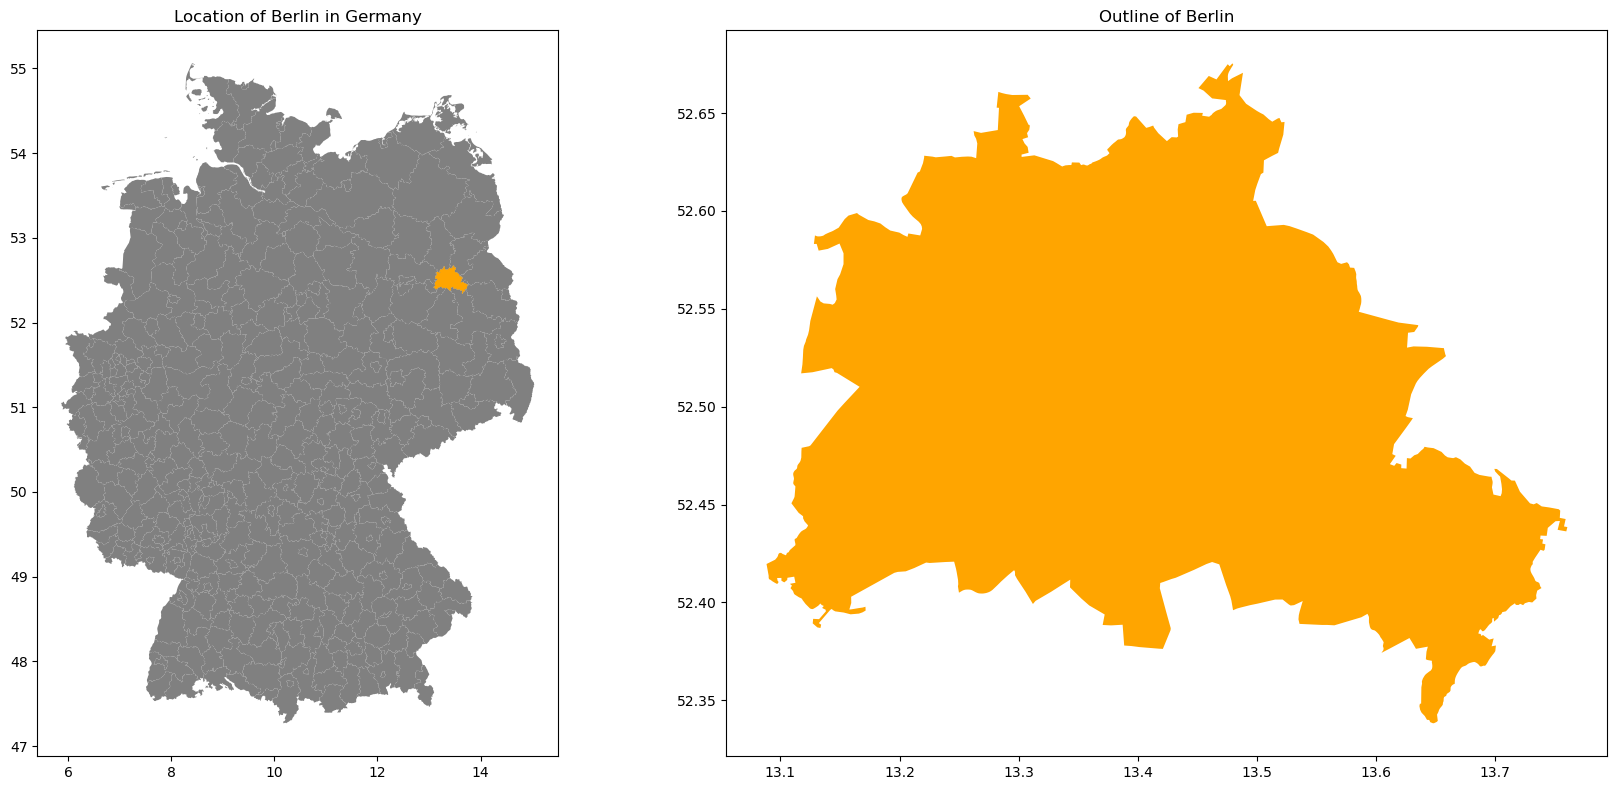

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 1 Zeile, 2 Spalten

cities_data.plot(color='grey', ax=axes[0])
outline_city.plot(color='orange', ax=axes[0])
axes[0].set_title(f"Location of {city} in Germany")

outline_city.plot(color='orange', ax=axes[1])
axes[1].set_title(f"Outline of {city}")

plt.tight_layout()
plt.show()

#### Other Data

##### External parking data

Here you can insert further parking data. If you dont have additional data just comment out those code lines.
This is used because parking data from OSM is often incomplete.

In [40]:
parking_extern = gpd.read_file('/Users/derjan/Desktop/Python/Data/02_Case Studies/Berlin/parking_lanes_berlin.gpkg')

Text(0.5, 1.0, 'Parking possibilities (external data)')

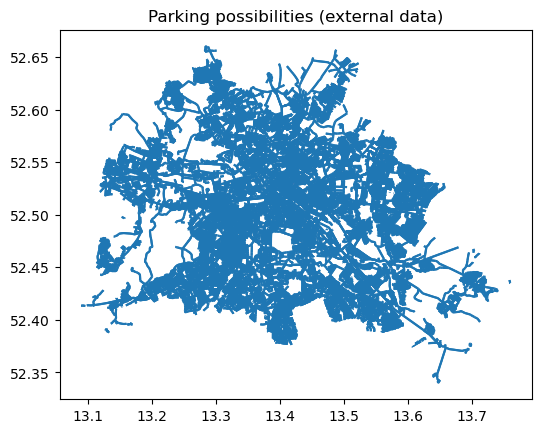

In [41]:
parking_extern.plot()
plt.title('Parking possibilities (external data)')

##### Data on registration numbers per district

Here you can insert further data on registration numbers. They will be implemented as factors on the population data. If you dont have these information just comment out those code lines.

<Axes: >

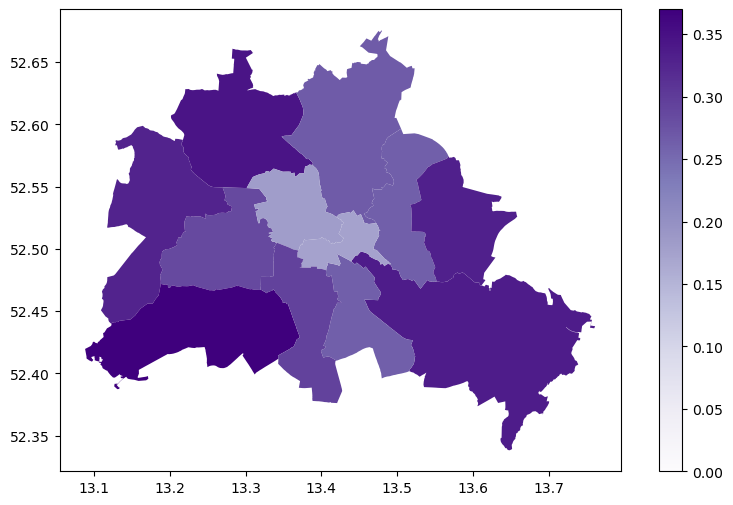

In [44]:
# Number of cars per inhabitants
car_per_1kinhabitants = pd.read_excel('/Users/derjan/Desktop/Python/Data/02_Case Studies/Berlin/Cars_per_1000_inhabitants_Bezirke.xlsx')

districts = gpd.read_file('/Users/derjan/Desktop/Python/Data/02_Case Studies/Berlin/bezirksgrenzen.shp')
districts_cars = districts.merge(car_per_1kinhabitants, on='Gemeinde_n')[['geometry','Gemeinde_n','number']]

districts_cars['factor'] = (districts_cars['number']) / 1000
districts_cars.plot(figsize = (10,6),column='factor',cmap='Purples', legend=True, vmin=0)
#plt.title('Distribution of cars per inhabitant')

Here you can insert data on the power grid.

In [46]:
'''power = powerdata'''

'power = powerdata'

### Data Sorting

#### Data Demand OpenStreetMaps

In [49]:
# Point- and area-values need to be condensed into single dataframes. They can be processed together.

pois = pd.concat([pois_free_1,pois_a_free_1], ignore_index=True)
pofw = pd.concat([pofw_free_1,pofw_a_free_1], ignore_index=True)
tran = pd.concat([transport_free_1,transport_a_free_1], ignore_index=True)
buil = buildings_a_free_1
land = landuse_a_free_1

In [50]:
# Here the relevant codes/ names for each demand criterion get set. The explanation and translation is given in the masters thesis.

codes_work_pois = [2081, 2084]

names_work_buil = ['industrial','office']

codes_shop = [2016,2501,2504,2505,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,
              2528,2529,2530,2541,2542,2543,2544,2546,2547]

codes_other_pois = [2007,2008,2009,2011,2012,2014,2110,2111,2120,2121,2129,2201,2202,2203,2251,2252,2254,2255,2256,2257,2301,
                    2302,2303,2304,2305,2306,2307,2401,2402,2403,2404,2405,2406,2424,2561,2567,2601,2721,2722,2743,2744]

codes_other_tran = [5601,5651,5652,5661,5671]

names_home_negative = ['house', 'detached' ,'semidetached_house' ,'bungalow' , 'garages', 'carport']

In [51]:
# The codes/ names from above are used to reduce the data and dataframes are joined together.

shop = pois[(pois['code'].isin(codes_shop))]

work_pois = pois[(pois['code'].isin(codes_work_pois))]
work_buil = buil[(buil['type'].isin(names_work_buil))]
work_buil.loc[:,'fclass'] = work_buil['type'] 
work = pd.concat([work_pois,work_buil], ignore_index=True)

other_pois = pois[(pois['code'].isin(codes_other_pois))]
other_pofw = pofw
other_tran = tran[(tran['code'].isin(codes_other_tran))]
other = pd.concat([other_pois, other_pofw, other_tran], ignore_index=True)

home = buil[(buil['type'].isin(names_home_negative))]

#### Data Demand Zensus 2022 (Data for Germany)

In [53]:
# Zensus geodata comes in a tabular form. It gets translated into a point form and then integrated into the grid.

geo_pop = gpd.GeoDataFrame(population_data, geometry=[shapely.geometry.Point(xy) for xy in zip(population_data['x_mp_100m'], population_data['y_mp_100m'])], crs = 'EPSG:3035')

pop = geo_pop.to_crs(epsg=4326)
pop = pop.drop(columns=['GITTER_ID_100m', 'x_mp_100m', 'y_mp_100m'])

#### Data Supply OpenStreetMaps

In [55]:
codes_road = [5112, 5113, 5114, 5115, 5121, 5122, 5123, 5143]

road = roads_free_1[(roads_free_1['code'].isin(codes_road))]

#road.plot(column='fclass', figsize=(10, 5), cmap="tab20", legend=True)

In [56]:
# Standard OSM data for parking is not good enough for Berlin. Because of that external data is used to complete the dataset.

traf = pd.concat([traffic_a_free_1,traffic_free_1,pois], ignore_index=True)

codes_parking = [2592, 5260, 5261, 5262, 5263]

parking = traf[(traf['code'].isin(codes_parking))]

In [57]:
if 'parking_extern' in locals():
    parking = pd.concat([parking, parking_extern], ignore_index=True)
else:
    print("Going on without external parking data.")

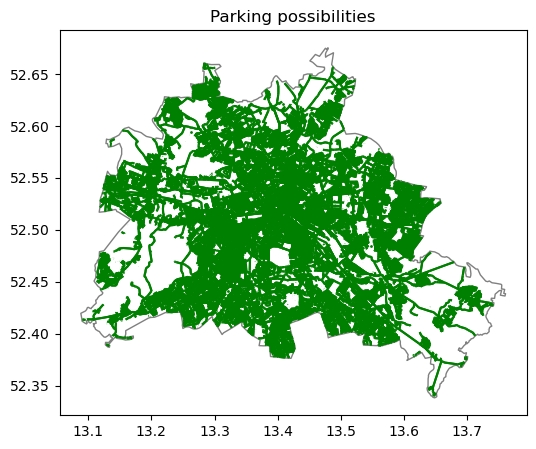

In [58]:
parking = parking[parking.within(outline_city.unary_union)]


fig, ax = plt.subplots(figsize=(10, 5))
parking.plot(figsize=(12, 8), color='green', ax=ax, markersize=1, legend=True)
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title("Parking possibilities")
plt.show()


In [59]:
codes_restr = [7210, 7213]

restr = land[(land['code'].isin(codes_restr))]

#restr.plot(column='fclass', figsize=(10, 5), cmap="tab20", legend=True)

#### Data existing Charging Points (Bundesnetzagentur)

In [61]:
# Transformation of the data from the Bundesnetzagentur regarding existing Charging Points into a coordinate format.
# A distinction is made here between fast chargers and normal chargers. This is not currently used in the methodology, but it may certainly be of interest for certain extensions or analyses.

bnetzdata = bnetz.copy()
bnetzdata = bnetzdata[['Breitengrad','Längengrad','Nennleistung Ladeeinrichtung [kW]','Art der Ladeeinrichung','Anzahl Ladepunkte']]
bnetzdata['Breitengrad'] = bnetzdata['Breitengrad'].str.replace(',', '.').astype(float)
bnetzdata['Längengrad'] = bnetzdata['Längengrad'].str.replace(',', '.').astype(float)
bnetzdata['Nennleistung Ladeeinrichtung [kW]'] = bnetzdata['Nennleistung Ladeeinrichtung [kW]'].str.replace(',', '.').astype(float)

charger = gpd.GeoDataFrame(bnetzdata, geometry=[shapely.geometry.Point(xy) for xy in zip(bnetzdata['Längengrad'], bnetzdata['Breitengrad'])], crs = 'EPSG:4326')
charger = charger.drop(columns=['Breitengrad','Längengrad'])
charger = charger.rename(columns={
    'Nennleistung Ladeeinrichtung [kW]': 'power',
    'Art der Ladeeinrichung': 'speed',
    'Anzahl Ladepunkte': 'points'
})

charger_normal = charger[charger['speed'] == 'Normalladeeinrichtung']
charger_fast = charger[charger['speed'] == 'Schnellladeeinrichtung']

#charger.plot(column='points', figsize=(12, 8), cmap='Blues', legend=True)
#charger_fast

## Method

### Grid Creation

In [64]:
# The grid is created based on the cities outline as well as the cell size.
grid = create_grid(gdf=outline_city, bounds=None, cell_size=.3, overlap=False, crs="EPSG:4326")

A 300.0 * 300.0 m grid was created. It contains 127 * 154 cells. (Sum: 19558 cells)
The factors for the coordinate conversion are: 
 x: 0.004401460226961973 
 y: 0.0026960525316042094


In [65]:
# The grid is sorted to be used in a tabular form.
grid.sort_values(["x","y"],inplace=True)
grid.reset_index(inplace=True, drop=True)

9510 cells are within the borders


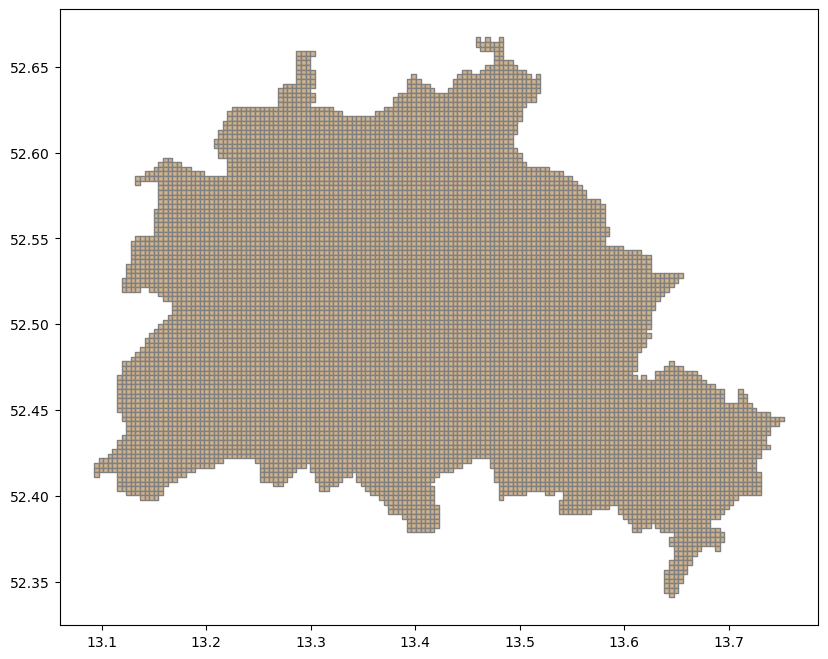

In [66]:
# Here you can plot the grid to see the grid size and the cells inside the cities area.
in_city = grid.copy()
in_city = in_city[in_city.within(outline_city.unary_union)]
in_city.plot( figsize=(10, 8), color='tan', edgecolor="grey", legend=True)

amount_in_city = in_city.shape[0]
print(f'{amount_in_city} cells are within the borders')

In [67]:
#These are the outer bounds of the cities coordinates.
outline_city.total_bounds

array([13.08833322, 52.33824184, 13.76046928, 52.67537882])

### Transforming data into Grid

#### Demand OSM

In [70]:
# Values are put into the grid with the grid filling function.

a_work = grid.copy()
for i in work['fclass'].unique():
        a_work = grid_filling(a_work, work[work['fclass']==i], i)

a_shop = grid.copy()
for i in shop['fclass'].unique():
        a_shop = grid_filling(a_shop, shop[shop['fclass']==i], i)

a_other = grid.copy()
for i in other['fclass'].unique():
        a_other = grid_filling(a_other, other[other['fclass']==i], i)

a_home = grid.copy()
for i in home['fclass'].unique():
        a_home = grid_filling(a_home, home[home['fclass']==i], i)

# for a_home only one fclass is used, so all values are added up.

#### Demand ZENSUS

In [72]:
a_pop = grid.copy()

# Population data gets into the grid differently because it needs to be summed and not counted, compared to other criterions.

merged = gpd.sjoin(pop,a_pop, how='left', predicate='intersects')

dissolve = merged.dissolve(by="index_right", aggfunc="sum")
a_pop.loc[dissolve.index, 'Einwohner'] = dissolve['Einwohner'].values

a_pop = a_pop.fillna(0)

#### Demand Cars

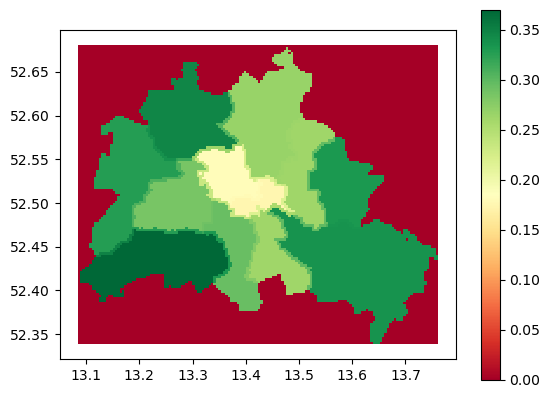

In [74]:
# If external vehicle date is given, it is also integrated. Otherwise this gets scipped and the factor is set to 1.

a_cars = grid.copy()

if 'districts_cars' in globals():
    merged = gpd.sjoin(districts_cars, a_cars, how='left', predicate='intersects')
    merged = merged.drop(columns=['Gemeinde_n'])
    
    dissolve = merged.dissolve(by="index_right", aggfunc="mean")
    a_cars.loc[dissolve.index, 'factor'] = dissolve['factor'].values
    a_cars = a_cars.fillna(0)
    
    #a_cars['factor'].value_counts()
    a_cars.plot(column='factor', cmap='RdYlGn', legend=True)
    
else:
    a_cars['factor'] = 1
    print('No vehicle data is imported.')



#### Supply OSM

In [76]:
a_road = grid.copy()

merged = gpd.sjoin(road, a_road, how='left', predicate='intersects')
merged['road_count'] = 1

dissolve = merged.dissolve(by="index_right", aggfunc="count")
a_road.loc[dissolve.index, 'road_count'] = dissolve['road_count'].values

a_road['road'] = np.where(a_road['road_count'].isna(), 0, 1)

supply = a_road.drop(columns='road_count')
#supply.plot(column='road', figsize=(8, 5), cmap='Blues', legend=True)

#a_road['road'].value_counts()

In [77]:
a_traf = grid.copy()

merged = gpd.sjoin(parking, a_traf, how='left', predicate='intersects')

merged['park_count'] = 1

dissolve = merged.dissolve(by="index_right", aggfunc="count")
a_traf.loc[dissolve.index, 'park_count'] = dissolve['park_count'].values

a_traf['park'] = np.where(a_traf['park_count'].isna(), 0, 1)


supply['park'] = a_traf['park']
#a_traf.plot(column='park', figsize=(12, 8), cmap='Blues', legend=True)

In [78]:
a_restr = grid.copy()

merged = gpd.sjoin(restr, a_restr, how='left', predicate='intersects')
merged['restriction'] = 1

dissolve = merged.dissolve(by="index_right", aggfunc="count")
a_restr.loc[dissolve.index, 'restriction'] = dissolve['restriction'].values

a_restr['restriction'] = np.where(a_restr['restriction'].isna(), 1, 0)


supply['restriction'] = a_restr['restriction']
#a_restr.plot(column='restriction', figsize=(12, 8), cmap='Blues', legend=True)

In [79]:
# Activate this cell if power grid data is used

'''a_power = grid.copy()

merged = gpd.sjoin(power, a_power, how='left', predicate='intersects')
merged['power'] = 1

dissolve = merged.dissolve(by="index_right", aggfunc="count")
a_power.loc[dissolve.index, 'power'] = dissolve['power'].values

a_power['power'] = np.where(a_power['power'].isna(), 1, 0)


supply['power'] = a_power['power']
#a_power.plot(column='power', figsize=(12, 8), cmap='Blues', legend=True)'''

'a_power = grid.copy()\n\nmerged = gpd.sjoin(power, a_power, how=\'left\', predicate=\'intersects\')\nmerged[\'power\'] = 1\n\ndissolve = merged.dissolve(by="index_right", aggfunc="count")\na_power.loc[dissolve.index, \'power\'] = dissolve[\'power\'].values\n\na_power[\'power\'] = np.where(a_power[\'power\'].isna(), 1, 0)\n\n\nsupply[\'power\'] = a_power[\'power\']\n#a_power.plot(column=\'power\', figsize=(12, 8), cmap=\'Blues\', legend=True)'

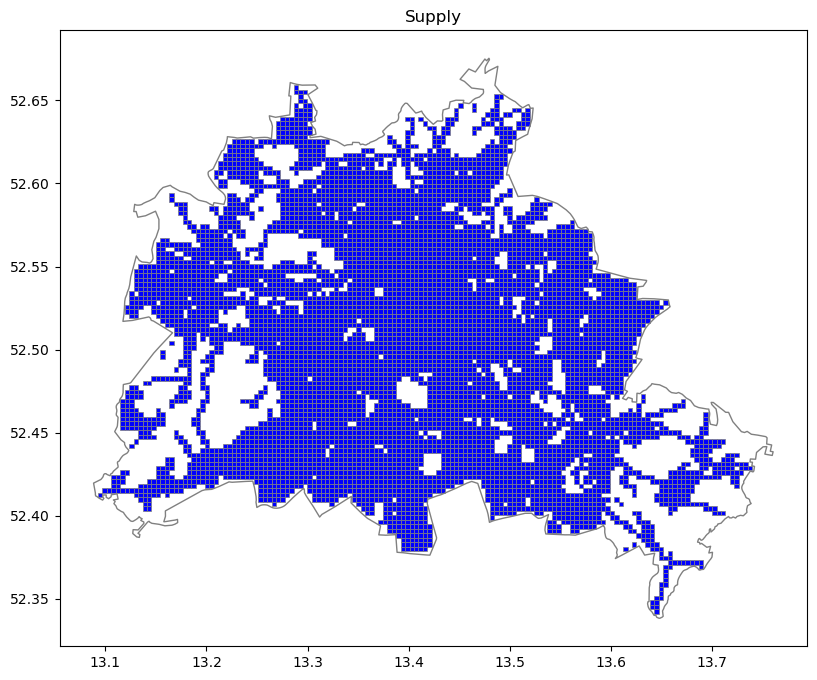

6918 out of 9510 grid cells are still available. (72.74%)


In [80]:
# Multiplication of the results
supply['sup'] = supply['road']  * supply['restriction'] * supply['park']#Add supply['power'] if you have data on power grid

touching_city = supply.within(outline_city.unary_union)
data_columns = supply.columns[3:]  
supply.loc[~touching_city, data_columns] = 0


fig, ax = plt.subplots(figsize=(10,8))
supply[supply['sup'] == 1].plot(figsize=(10,8), color='blue', edgecolor='grey', ax=ax, linewidth = .5, legend=True)
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title("Supply")
plt.show()

free = supply['sup'].value_counts()[1]

print(f'{free} out of {amount_in_city} grid cells are still available. ({free/amount_in_city*100:.2f}%)')

#### Existing Chargers

Here, the data of existing chargers is integrated into the grid format.

In [83]:
a_charger_normal = grid.copy()

merged = gpd.sjoin(charger_normal, a_charger_normal, how='left', predicate='intersects')
#merged['cpo'] = 1
# Aggregate data by count-variable + back to df
dissolve = merged.dissolve(by="index_right", aggfunc="sum")
a_charger_normal.loc[dissolve.index, 'points'] = dissolve['points'].values
a_charger_normal = a_charger_normal.fillna(0)

#a_charger_normal.plot(column='points', figsize=(12, 8), cmap='binary', legend=True)
#plt.title(f'Existing normal chargers (n = {int(sum(a_charger_normal['points']))})')

In [84]:
a_charger_fast = grid.copy()

merged = gpd.sjoin(charger_fast, a_charger_fast, how='left', predicate='intersects')
#merged['cpo'] = 1
# Aggregate data by count-variable + back to df
dissolve = merged.dissolve(by="index_right", aggfunc="sum")
a_charger_fast.loc[dissolve.index, 'points'] = dissolve['points'].values
a_charger_fast = a_charger_fast.fillna(0)

#a_charger_fast.plot(column='points', figsize=(12, 8), cmap='binary', legend=True)
#plt.title(f'Existing fast chargers (n = {int(sum(a_charger_fast['points']))})')

In [85]:
urban_chargers_all = a_charger_normal.copy()
urban_chargers_all['points'] += a_charger_fast['points']

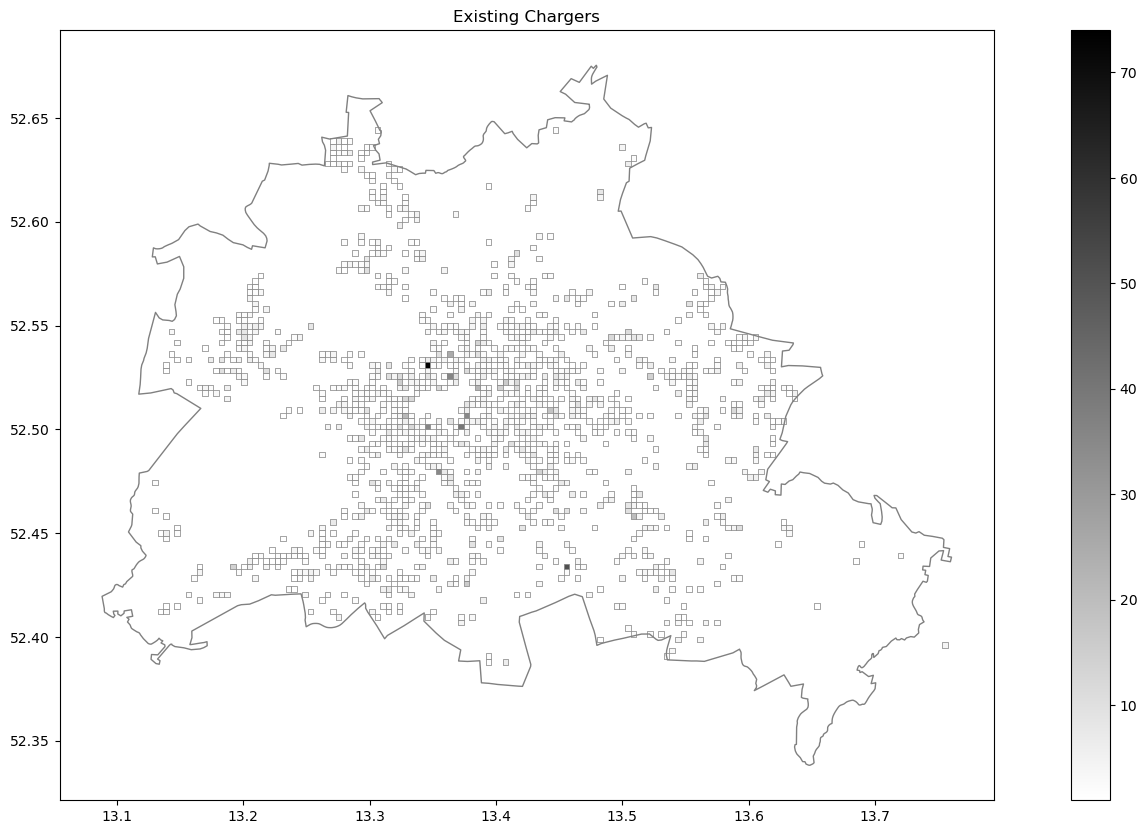

In [86]:
fig, ax = plt.subplots(figsize=(20, 10))
urban_chargers_all[urban_chargers_all['points']!=0].plot(figsize=(12, 8), column='points', cmap='binary', edgecolor='grey', ax=ax, linewidth = .5, legend=True)
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title("Existing Chargers")
plt.show()

### Limitation to urban boarders

To be sure that no values outside the city limits are included, these are excluded here. This is important for the TOPSIS calculation, as the values could have an influence on the positive or negative ideal solution. 

This is not important for other areas, as the results will be narrowed down to the urban area later on.

In [89]:
geo_dfs = [a_other, a_work, a_shop, a_home, a_pop, a_cars, supply]#, a_charger_normal, a_charger_fast]

for gdf in geo_dfs:
    touching_city = gdf.within(outline_city.unary_union)
    data_columns = gdf.columns[3:]  
    gdf.loc[~touching_city, data_columns] = 0

### TOPSIS

Here, the TOPSIS function and other calculations are applied to the data within the cells.

In [92]:
at_work = topsis(a_work)[['geometry','x','y','TOP']]
at_shop = topsis(a_shop)[['geometry','x','y','TOP']]
at_other = topsis(a_other)[['geometry','x','y','TOP']]
at_home_bui = topsis_complex(a_home,false_if_neg= [False])[['geometry','x','y','TOP']]

a_home_bev = at_home_bui.merge(a_pop[['x','y', 'Einwohner']], on=['x','y'], how='outer')
a_home_bev['inhabitants_balanced'] = a_home_bev['Einwohner'] * a_home_bev['TOP']
a_home_bev = a_home_bev.drop(columns=['TOP', 'Einwohner'])

a_home_cars = a_home_bev.merge(a_cars[['x','y', 'factor']], on=['x','y'], how='outer')
a_home_cars['cars_balanced'] = a_home_cars['inhabitants_balanced'] * a_home_cars['factor']
a_home_cars = a_home_cars.drop(columns=['inhabitants_balanced', 'factor'])

at_home = topsis(a_home_cars)[['geometry','x','y','TOP']]

#at_other.plot(column='TOP', figsize=(12, 8), cmap='RdYlGn', edgecolor="grey", linewidth=.5, legend=True)

At this point, the total number of inhabitants in the urban area is estimated on the basis of the census data. This number should roughly resemble the actual number of inhabitants, otherwise an error has occurred.

Deviations are explained not by current or perfect data, but by border cells that are not completely within the city and have therefore not been included.

In [94]:
a_pop['Einwohner'].sum()

3547464.0

At this point, the TOPSIS results for the charging types are summarized and added up.

In [96]:
combined = at_work.merge(at_shop[['x','y', 'TOP']], on=['x','y'], how='outer', suffixes=('_work', '_shop'))
combined = combined.merge(at_other[['x','y', 'TOP']], on=['x','y'], how='outer')
combined = combined.merge(at_home[['x','y', 'TOP']], on=['x','y'], how='outer', suffixes=('_other', '_home'))

columns_normalize = ['TOP_work', 'TOP_shop', 'TOP_other', 'TOP_home']


for column in columns_normalize:
    max_value = combined[column].max()
    combined[column] = combined[column] / max_value

# the unweighted results will later be relevant for the analysis of the placed chargers
topsis_result_unweighted = combined.copy()

for column, weight in zip(columns_normalize, weights_chargin):
    combined[column] = combined[column] * weight * 100

combined['TOP'] = combined['TOP_work'] + combined['TOP_shop'] + combined['TOP_other'] + combined['TOP_home']

hochi = combined['TOP'].idxmax()
#print(combined.loc[hochi])

topsis_result = combined.copy()
#topsis_result[topsis_result['TOP_shop']!=0]

#topsis_result['TOP_home'].value_counts()

#topsis_result.plot(column='TOP_work', figsize=(12, 8), cmap='RdYlGn', edgecolor="grey", linewidth=.5, legend=True)

In [97]:
# Topsis_result gets rescaled to a scale of 0 to 100. 
topsis_result_max = max(topsis_result['TOP'])

topsis_result['TOP'] = topsis_result['TOP'] / topsis_result_max * 100

<Axes: >

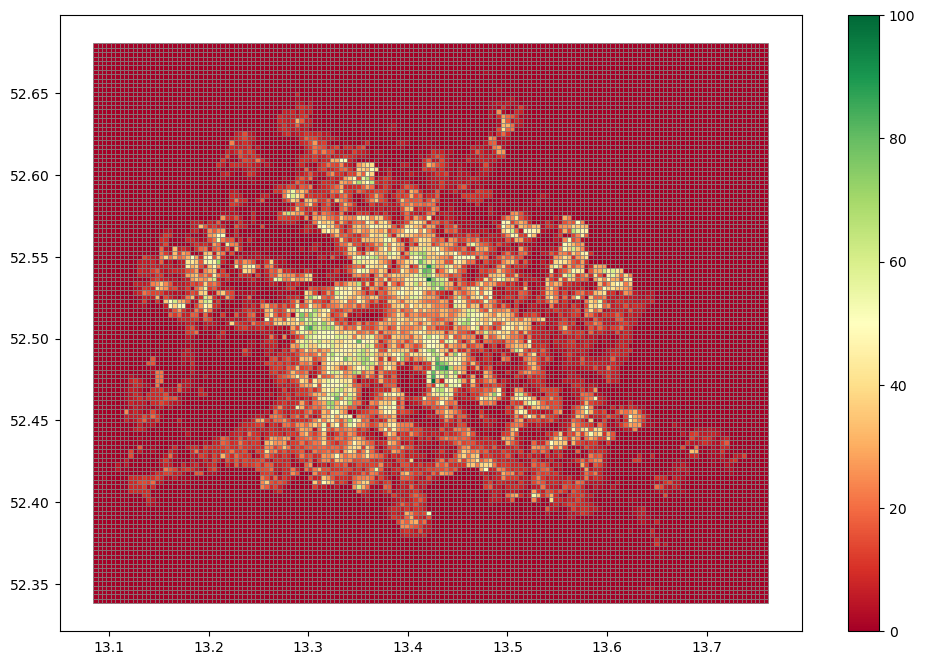

In [98]:
topsis_result.plot(column='TOP', figsize=(12, 8), cmap='RdYlGn', edgecolor="grey", linewidth = .5, legend=True)

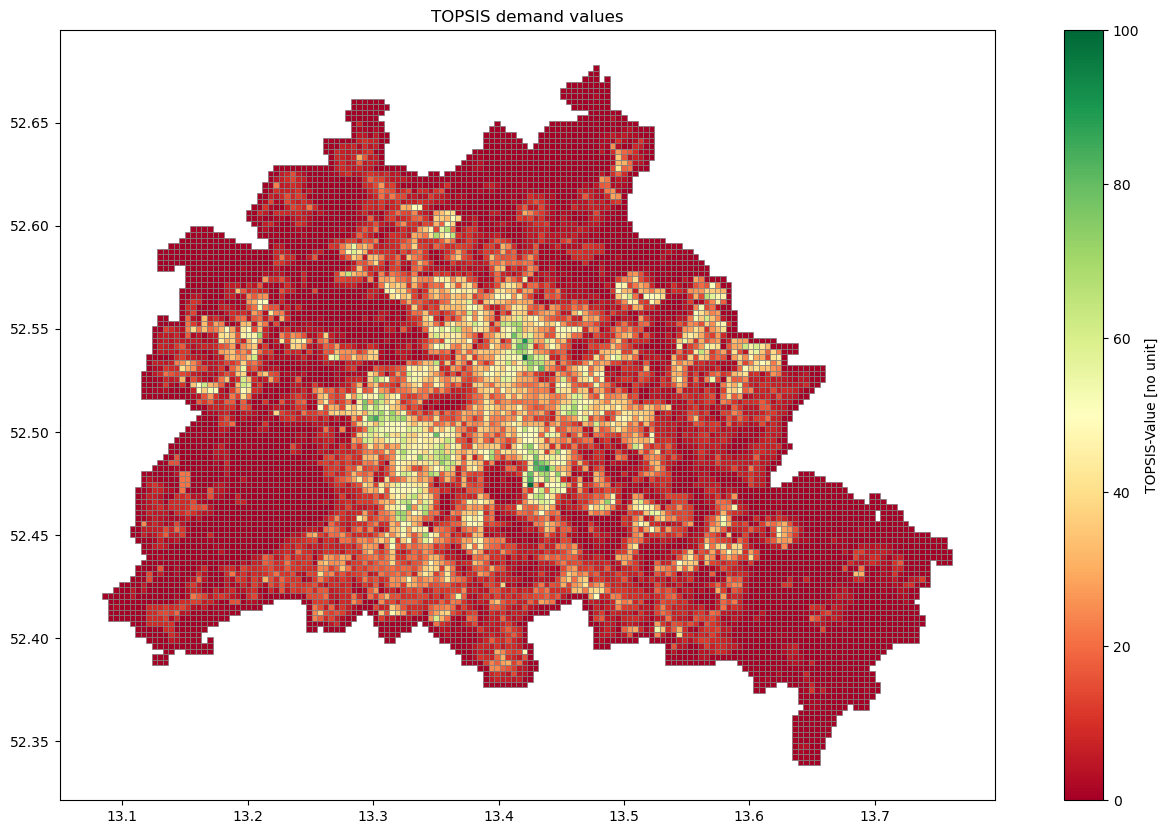

In [99]:
# This restriction is only used for plotting.
urban_plot = gpd.sjoin(topsis_result, outline_city, how='inner', predicate='intersects')

# Ausgabe des gefilterten GeoDataFrames
ax = urban_plot.plot(column='TOP', figsize=(18, 10), cmap='RdYlGn', edgecolor="grey", linewidth = .5 , legend=True, legend_kwds={'label': "TOPSIS-Value [no unit]"})
plt.title('TOPSIS demand values')
plt.savefig('/Users/derjan/Desktop/Python/Plots/topsis_print.png',dpi=300)
plt.show()

This part is used to plot the TOPSIS results of the four different charging types.

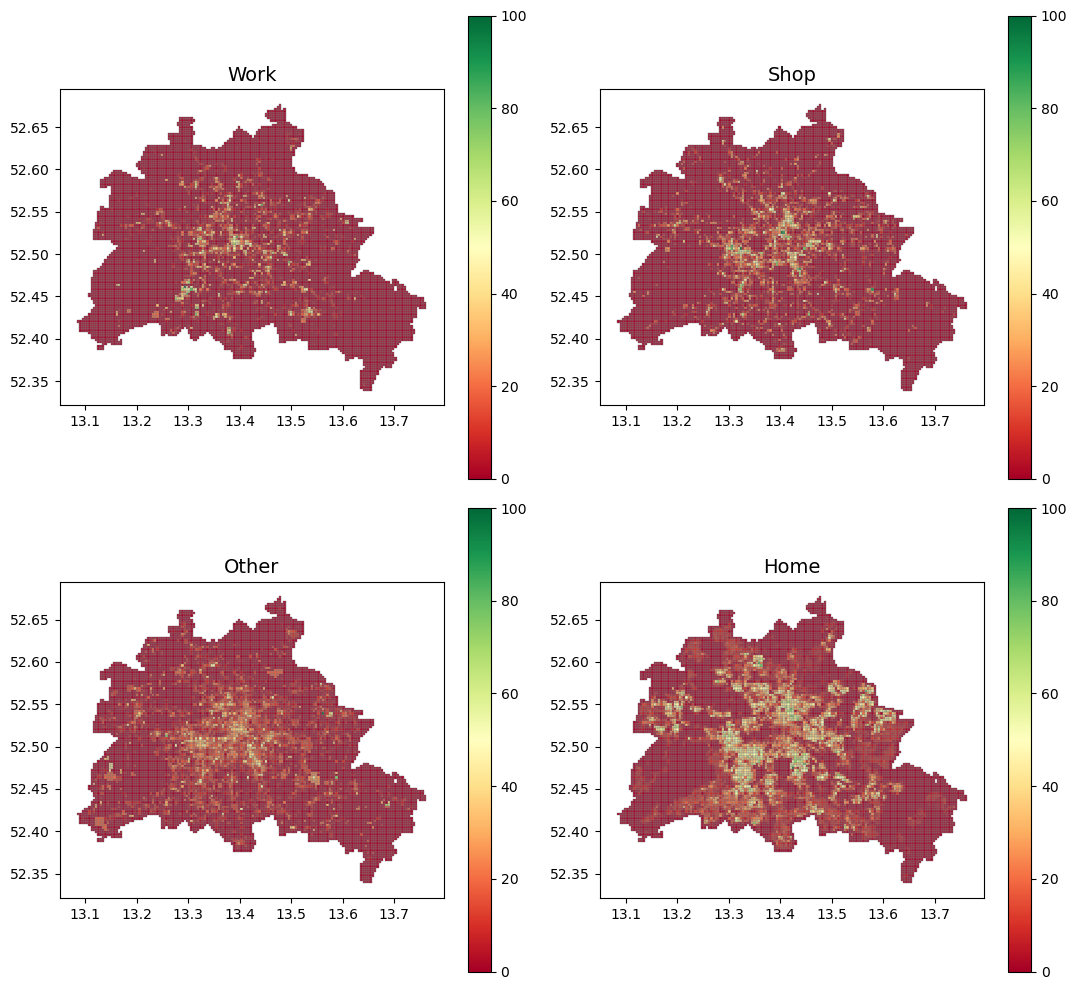

In [101]:
fourplot = urban_plot.copy()

columns = ['TOP_work', 'TOP_shop', 'TOP_other', 'TOP_home']

for column in columns:
    max_value = fourplot[column].max()  # Maximalwert der Spalte
    fourplot[column] = (fourplot[column] / max_value) * 100  # Normalisierung in Prozent


vmin = fourplot[['TOP_work', 'TOP_shop', 'TOP_other', 'TOP_home']].min().min()
vmax = fourplot[['TOP_work', 'TOP_shop', 'TOP_other', 'TOP_home']].max().max()

# Erstelle die Subplots
fig, axes = plt.subplots(2, 2, figsize=(11,10))

# Spaltennamen und Titel für jeden Subplot
titles = ['Work', 'Shop', 'Other', 'Home']

for ax, column, title in zip(axes.flatten(), columns, titles):
    fourplot.plot(
        column=column,
        ax=ax,
        cmap='RdYlGn',
        edgecolor='grey',
        linewidth=0.3,
        vmin=vmin,
        vmax=vmax,
        legend=True
    )
    ax.set_title(title, fontsize=14)

# Layout anpassen
plt.tight_layout()
plt.show()

### Placement

The placement function. The function itself can be found under the “Other functions” section. At this point, only the factors of the neighboring cells are to be entered, which are 0.4 and 0.12 for the current charging point stamp.

In [104]:
dem, pla, chargers_existing, chargers_placed, list_placements = placement(demand_in = topsis_result, supply_in= supply, 
        existing_chargers= urban_chargers_all, charger_amount_overall=charger_amount_overall, factor_neighbours_d1= .4 , factor_neighbours_d2= .12)



Overall 50884 charging points are to be placed. 4473 charging points are already installed so 46411 need to get planned. 
Overall there is a demand of 111189.96. Divided by 50884 points it results in 2.19 demand reduction per point.
This results in a decrease value of 0.28904 for the main cell and 0.11562 / 0.03469 for the neighbours of first / second degree.
The largest remaining demand is 24.92.
Use of the 1-cell criterion: 4160 of 46411 placements. (8.96%)
Duration: 24.36 seconds
Distribution completed successfully!


#### Conversion to GeoDataFrame

In [106]:
results = topsis_result_unweighted.copy()
results['remaining_demand'] = [dem[x, y] for x, y in zip(results['x'], results['y'])]
results['chargers_placed'] = [pla[x, y] for x, y in zip(results['x'], results['y'])]
results['chargers_existing'] = [chargers_existing[x, y] for x, y in zip(results['x'], results['y'])]
results['chargers_sum'] = results['chargers_placed'] + results['chargers_existing']
results

max_legend = max(results['chargers_sum'])

The results can be output in the simplest form as a data frame. In addition to the existing chargers, the placed chargers and the topsis values per cell can also be viewed and evaluated here. The coordinates for each cell are also given.

This data is visualized in the further course of the process.

In [108]:
results[results['chargers_sum'] != 0].head(10)

geometry   x   y  TOP_work  \
2052  POLYGON ((13.30400 52.64290, 13.30400 52.64559...  13  50  0.000000   
2084  POLYGON ((13.44485 52.64290, 13.44485 52.64559...  13  82  0.000000   
2203  POLYGON ((13.29080 52.64020, 13.29080 52.64290...  14  47  0.000000   
2204  POLYGON ((13.29520 52.64020, 13.29520 52.64290...  14  48  0.000000   
2253  POLYGON ((13.51087 52.64020, 13.51087 52.64290...  14  97  0.000000   
2352  POLYGON ((13.26879 52.63750, 13.26879 52.64020...  15  42  0.000000   
2353  POLYGON ((13.27319 52.63750, 13.27319 52.64020...  15  43  0.000000   
2354  POLYGON ((13.27760 52.63750, 13.27760 52.64020...  15  44  0.000000   
2355  POLYGON ((13.28200 52.63750, 13.28200 52.64020...  15  45  0.000000   
2402  POLYGON ((13.48887 52.63750, 13.48887 52.64020...  15  92  0.041535   

      TOP_shop  TOP_other  TOP_home  remaining_demand  chargers_placed  \
2052  0.000000   0.000000  0.000000         -1.167734                0   
2084  0.000000   0.000000  0.000000         -0.578086                0   
2203  0.000000   0.058345  0.087992          4.461631                7   
2204  0.000000   0.000000  0.091899          3.542875                8   
2253  0.246397   0.032928  0.026404          7.584803               11   
2352  0.000000   0.000000  0.000000         -1.815190                0   
2353  0.000000   0.000000  0.086988          4.186544                0   
2354  0.000000   0.000000  0.068156          1.693291                0   
2355  0.000000   0.000000  0.094285          3.203898                0   
2402  0.000000   0.100034  0.238610         13.696539               30   

      chargers_existing  chargers_sum  
2052                2.0           2.0  
2084                2.0           2.0  
2203                0.0           7.0  
2204                0.0           8.0  
2253                0.0          11.0  
2352                1.0           1.0  
2353                5.0           5.0  
2354                1.0           1.0  
2355                2.0           2.0  
2402                0.0          30.0

## Review of the results

In [110]:
#In addition to the values of the city, the array also includes the values of the surrounding area, as it represents a rectangle. 
#For statistical purposes, it is therefore better to exclude values that are exactly zero. 
filtered_demand = results[results['remaining_demand']!=0]

In [111]:
print('The remaining demand is now being analyzed. Ideally, all values are zero.')
print(f'Variance: {filtered_demand['remaining_demand'].var():.2f}')
print(f'Minimum: {filtered_demand['remaining_demand'].min():.2f}')
print(f'Maximum: {filtered_demand['remaining_demand'].max():.2f}')
print(f'Range: {filtered_demand['remaining_demand'].max()-results['remaining_demand'].min():.2f}')
print(f'Median: {filtered_demand['remaining_demand'].median():.2f}')
print(f'Mean: {filtered_demand['remaining_demand'].mean():.2f}')
print(f'IQR: {filtered_demand['remaining_demand'].quantile(0.75) - results['remaining_demand'].quantile(0.25):.2f}')

The remaining demand is now being analyzed. Ideally, all values are zero.
Variance: 38.26
Minimum: -38.96
Maximum: 24.92
Range: 63.88
Median: -0.17
Mean: 0.00
IQR: 3.24


In [112]:
sum_pos_dem = filtered_demand[filtered_demand['remaining_demand']>0]['remaining_demand'].sum()
print(f'The sum of all cells with a remaining positive remaining demand is {sum_pos_dem:.0f}.')

print(f'This corresponds to {100 * (sum_pos_dem / topsis_result['TOP'].sum()):.2f} % of the overall demand before the placement.')

The sum of all cells with a remaining positive remaining demand is 19940.
This corresponds to 17.93 % of the overall demand before the placement.


The 10 largest values of the remaining demand are displayed here. This is important because sometimes a few cells may have exceptionally high values because no charging points can be placed due to a lack of supply. To evaluate the overall placement, you should then look at the first “normal” values, which you can recognize by the fact that they are very similar to their subsequent values (deviation less than 3-5).

In [114]:
filtered_demand['remaining_demand'].nlargest(10)

6253     24.918463
14304    24.864691
6254     19.584640
11565    19.516222
11718    19.516222
11719    19.516222
11872    18.545038
11411    17.897581
11564    17.816649
13799    16.641113
Name: remaining_demand, dtype: float64

In the following two cells, the distribution of charging points among the individual charging types is estimated. As described in the study, this should not be used as an optimization, since this estimate does not include neighboring cells and is therefore not as accurate as the placement itself.

In [116]:
analysis1 = results.copy()

analysis1['TOP_sum'] = analysis1['TOP_work'] + analysis1['TOP_shop'] + analysis1['TOP_other'] + analysis1['TOP_home']
analysis1['decrease_factor'] = analysis1['TOP_sum'] / analysis1['chargers_placed']
analysis1[['ch_work', 'ch_shop', 'ch_other', 'ch_home']] = 0

for index, row in analysis1[analysis1['chargers_placed'] > 0].iterrows():
    chargers_to_place = int(row['chargers_placed'])
    
    for _ in range(chargers_to_place):
        top_columns = ['TOP_work', 'TOP_shop', 'TOP_other', 'TOP_home']
        top_values = analysis1.loc[index, top_columns] 
        max_top_col = top_values.idxmax()

        ch_column = 'ch_' + max_top_col.split('_')[1] 
        analysis1.at[index, ch_column] += 1 

        analysis1.at[index, max_top_col] -= analysis1.at[index, 'decrease_factor']

In [117]:
order = ['work','shop','other','home']
counts = []
percentages = []
total_sum = analysis1[['ch_work', 'ch_shop', 'ch_other', 'ch_home']].sum().sum()

for category in order:
    column_name = f"ch_{category}"
    count = analysis1[column_name].sum()
    counts.append(count)
    percentages.append(count / total_sum)

analysis_df = pd.DataFrame({
    "Category": order,
    "Count": counts,
    "Share": percentages
})

analysis_df['Target'] = weights_chargin
analysis_df['Diff'] = analysis_df['Share'] - analysis_df['Target']

analysis_df['Share'] = analysis_df['Share'] * 100
analysis_df['Target'] = analysis_df['Target'] * 100
analysis_df['Diff'] = analysis_df['Diff'] * 100

analysis_df['Share'] = analysis_df['Share'].map('{:.2f}%'.format)
analysis_df['Target'] = analysis_df['Target'].map('{:.2f}%'.format)
analysis_df['Diff'] = analysis_df['Diff'].map('{:.1f}%'.format)

print(analysis_df)


  Category  Count   Share  Target   Diff
0     work   2843   6.13%   9.89%  -3.8%
1     shop   9427  20.31%  16.39%   3.9%
2    other   9115  19.64%  27.43%  -7.8%
3     home  25026  53.92%  46.28%   7.6%


#### Visualization

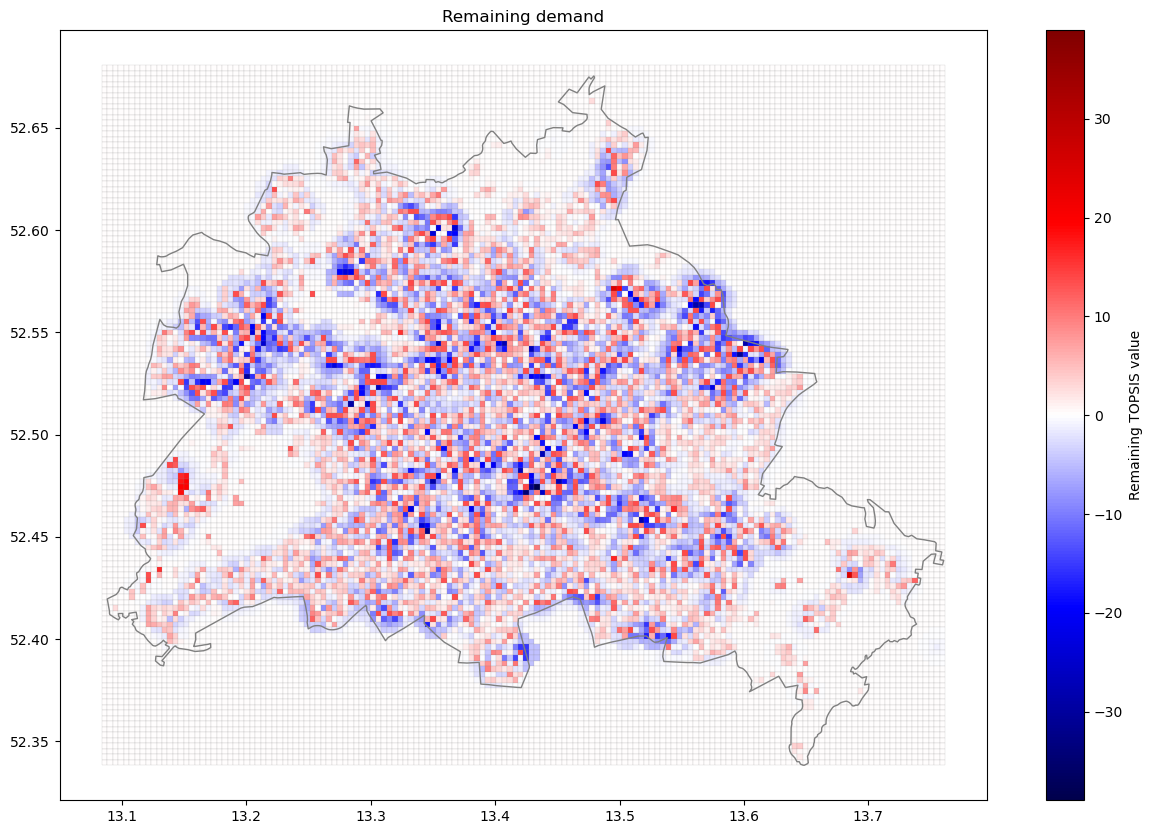

In [119]:
max_value = max(abs(results['remaining_demand'].min()), abs(results['remaining_demand'].max()))
norm = mcolors.TwoSlopeNorm(vmin=-max_value, vcenter=0, vmax=max_value)

fig, ax = plt.subplots(figsize=(15, 10))
results.plot(
    column='remaining_demand', 
    cmap='seismic', 
    legend=True, 
    edgecolor="grey", 
    linewidth=0.1, 
    ax=ax, 
    norm=norm,  # Verwenden Sie die benutzerdefinierte Normierung
    legend_kwds={'label': 'Remaining TOPSIS value'}
)
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title("Remaining demand")
plt.show()

The following illustration can be used to check wether gigh remaining demand values may be due to a missing supply.
All red dots that can be seen have not met the supply criterion.

In [121]:
remaining_dem_threshold = 20

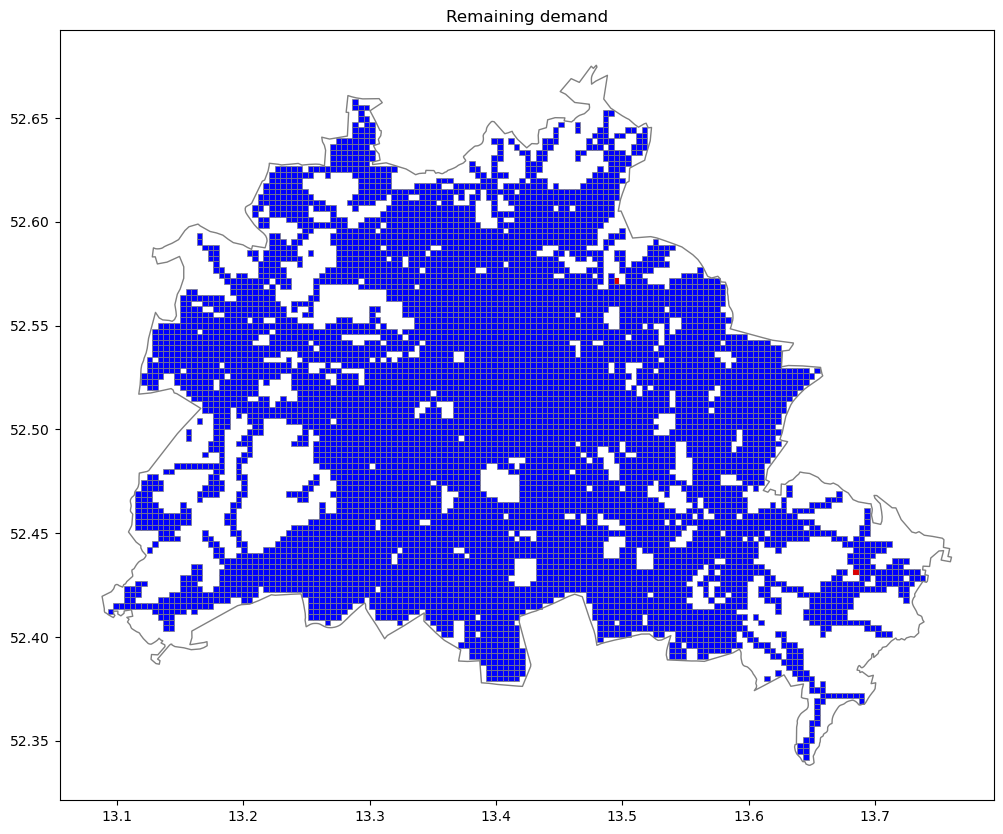

In [234]:
max_value = max(abs(results['remaining_demand'].min()), abs(results['remaining_demand'].max()))
norm = mcolors.TwoSlopeNorm(vmin=-max_value, vcenter=0, vmax=max_value)

fig, ax = plt.subplots(figsize=(15, 10))
results[results['remaining_demand']>remaining_dem_threshold].plot(
    column='remaining_demand', 
    cmap='seismic', 
    edgecolor="grey", 
    linewidth=0.1, 
    ax=ax, 
    norm=norm,  # Verwenden Sie die benutzerdefinierte Normierung
    legend_kwds={'label': 'Remaining TOPSIS value'}
)
supply[supply['sup'] == 1].plot(color='blue', edgecolor='grey', ax=ax, linewidth = .5, legend=True)
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title("Remaining demand")
plt.show()

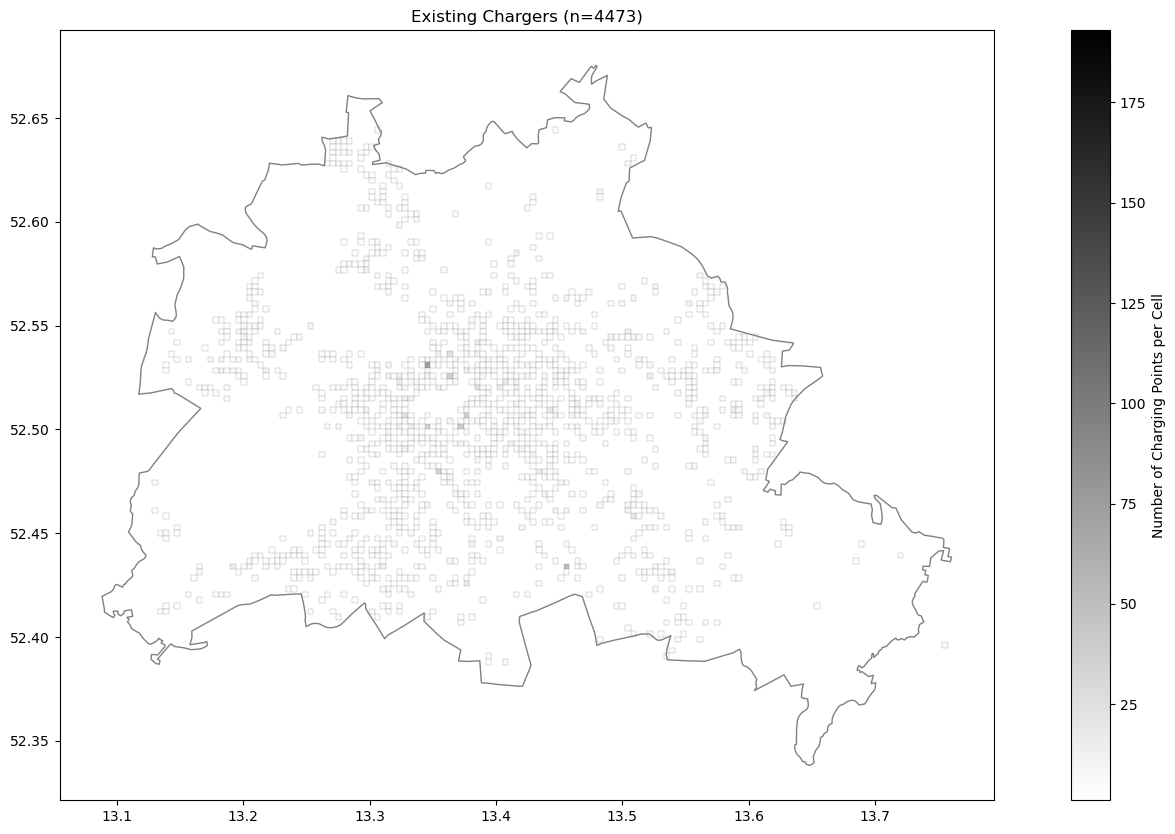

In [123]:
fig, ax = plt.subplots(figsize=(20,10))
results[results['chargers_existing'] != 0].plot(column='chargers_existing', cmap='binary', 
    edgecolor="grey", linewidth = .2, legend=True, ax=ax, vmax = max_legend , legend_kwds={'label': 'Number of Charging Points per Cell'})
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title(f"Existing Chargers (n={int(chargers_existing.sum())})")
plt.show()

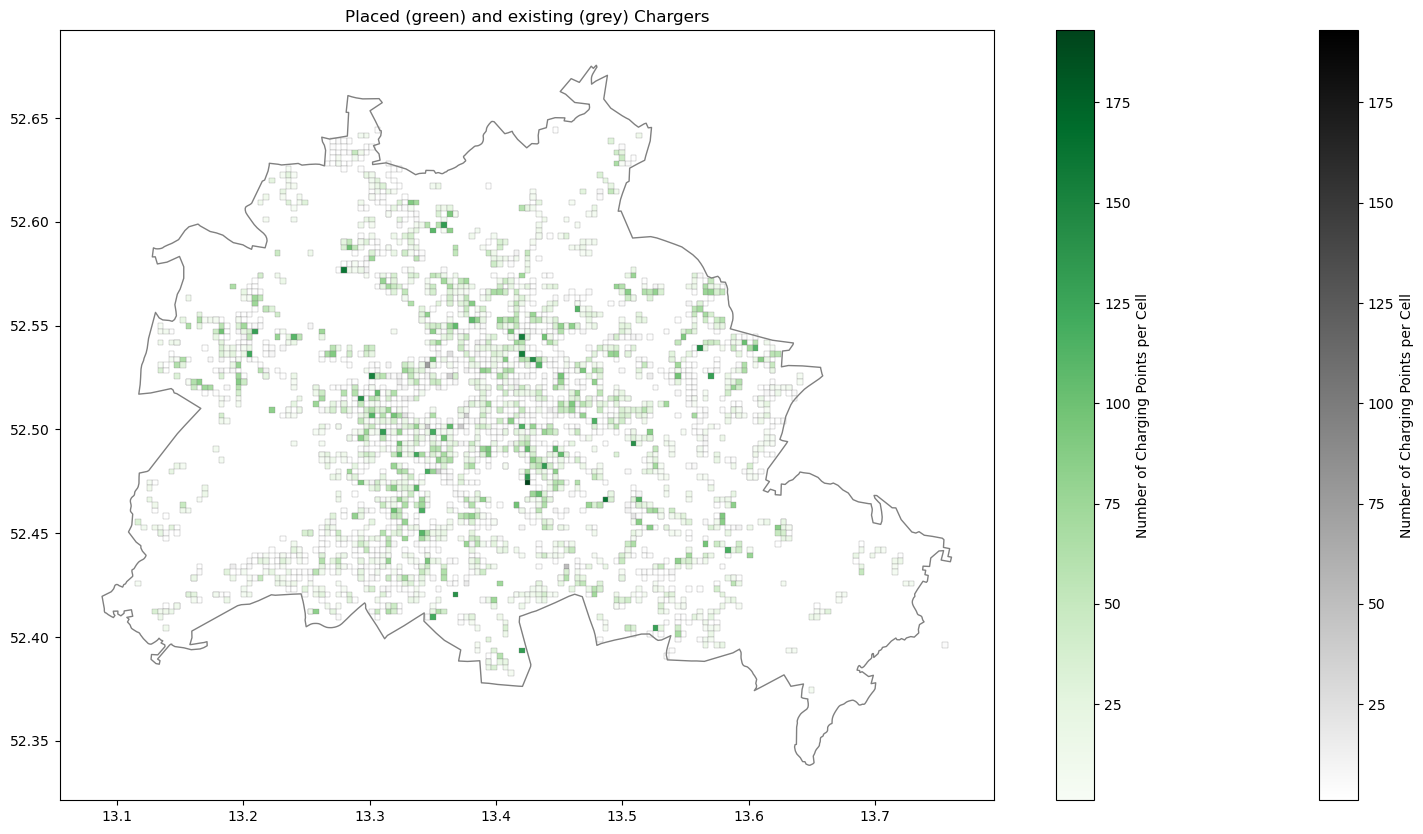

In [124]:
fig, ax = plt.subplots(figsize=(20,10))
results[results['chargers_existing'] != 0].plot(column='chargers_existing', cmap='binary', 
    edgecolor="grey", linewidth = .2, legend=True, ax=ax, vmax = max_legend , legend_kwds={'label': 'Number of Charging Points per Cell'})
results[results['chargers_placed'] != 0].plot(column ='chargers_placed' , cmap='Greens', edgecolor="grey", 
                    linewidth=.2, legend=True, ax=ax, vmax = max_legend, legend_kwds={'label': 'Number of Charging Points per Cell'})
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title("Placed (green) and existing (grey) Chargers")
plt.show()

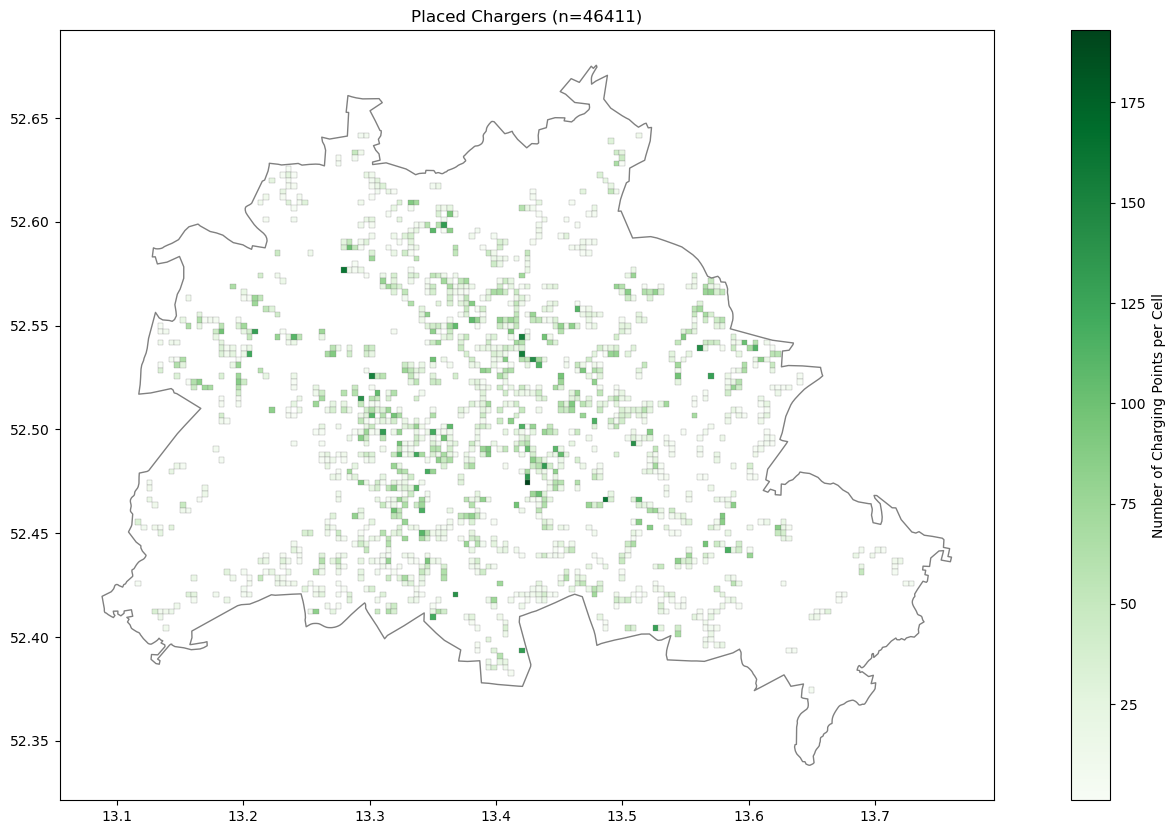

In [125]:
fig, ax = plt.subplots(figsize=(20,10))
results[results['chargers_placed'] != 0].plot(column ='chargers_placed' , cmap='Greens', edgecolor="grey", 
                    linewidth=.2, legend=True, ax=ax, vmax = max_legend, legend_kwds={'label': 'Number of Charging Points per Cell'})
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title(f"Placed Chargers (n={chargers_placed})")
plt.show()

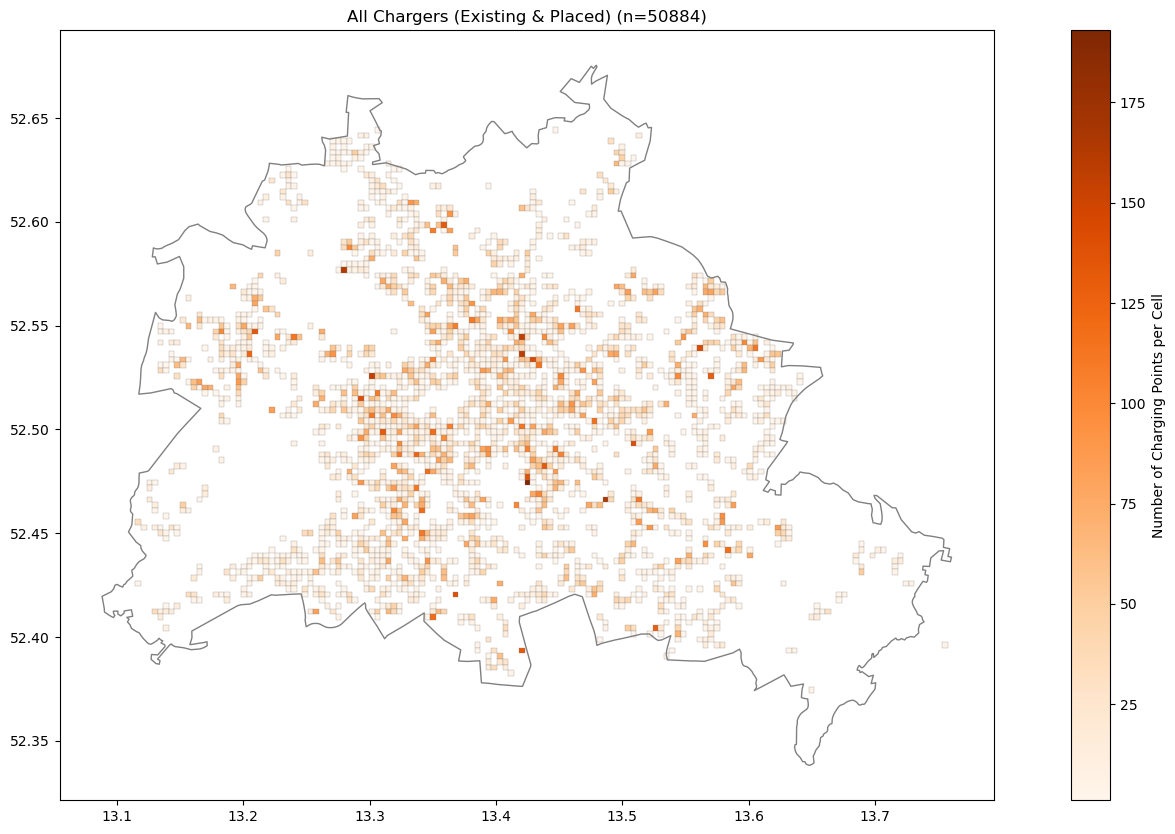

In [126]:
fig, ax = plt.subplots(figsize=(20,10))
results[results['chargers_sum'] != 0].plot(column='chargers_sum', cmap='Oranges', legend=True, ax=ax, edgecolor="grey", 
                                           linewidth=.2, vmax = max_legend, legend_kwds={'label': 'Number of Charging Points per Cell'})
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title(f"All Chargers (Existing & Placed) (n={int(chargers_existing.sum()) + chargers_placed})")
plt.show()

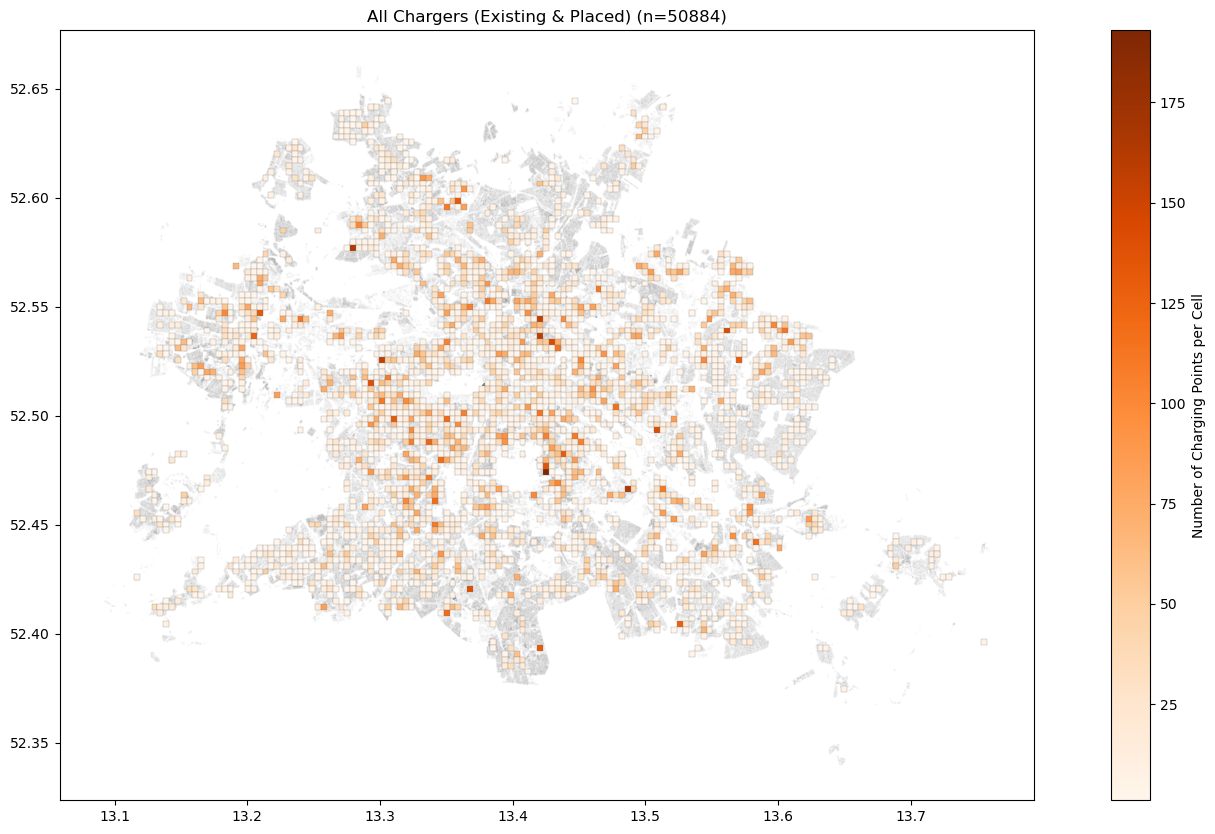

In [127]:
buil_within_city = buil[buil.within(outline_city.unary_union)]

fig, ax = plt.subplots(figsize=(20,10))
buil_within_city.plot(ax=ax, facecolor="grey", edgecolor="grey", linewidth=1, alpha=.03)
results[results['chargers_sum'] != 0].plot(column='chargers_sum', cmap='Oranges', legend=True, ax=ax, edgecolor='grey', linewidth=.2,
                                        vmax = max_legend, alpha = 1,legend_kwds={'label': 'Number of Charging Points per Cell'})
plt.title(f"All Chargers (Existing & Placed) (n={int(chargers_existing.sum()) + chargers_placed})")
plt.show()

### Further calculation and visualization

In [129]:
selected_columns = ['geometry', 'x', 'y', 'remaining_demand', 'chargers_placed', 'chargers_existing', 'chargers_sum', 
                    'ch_work', 'ch_shop', 'ch_other', 'ch_home']
charger_types = analysis1[selected_columns].copy()

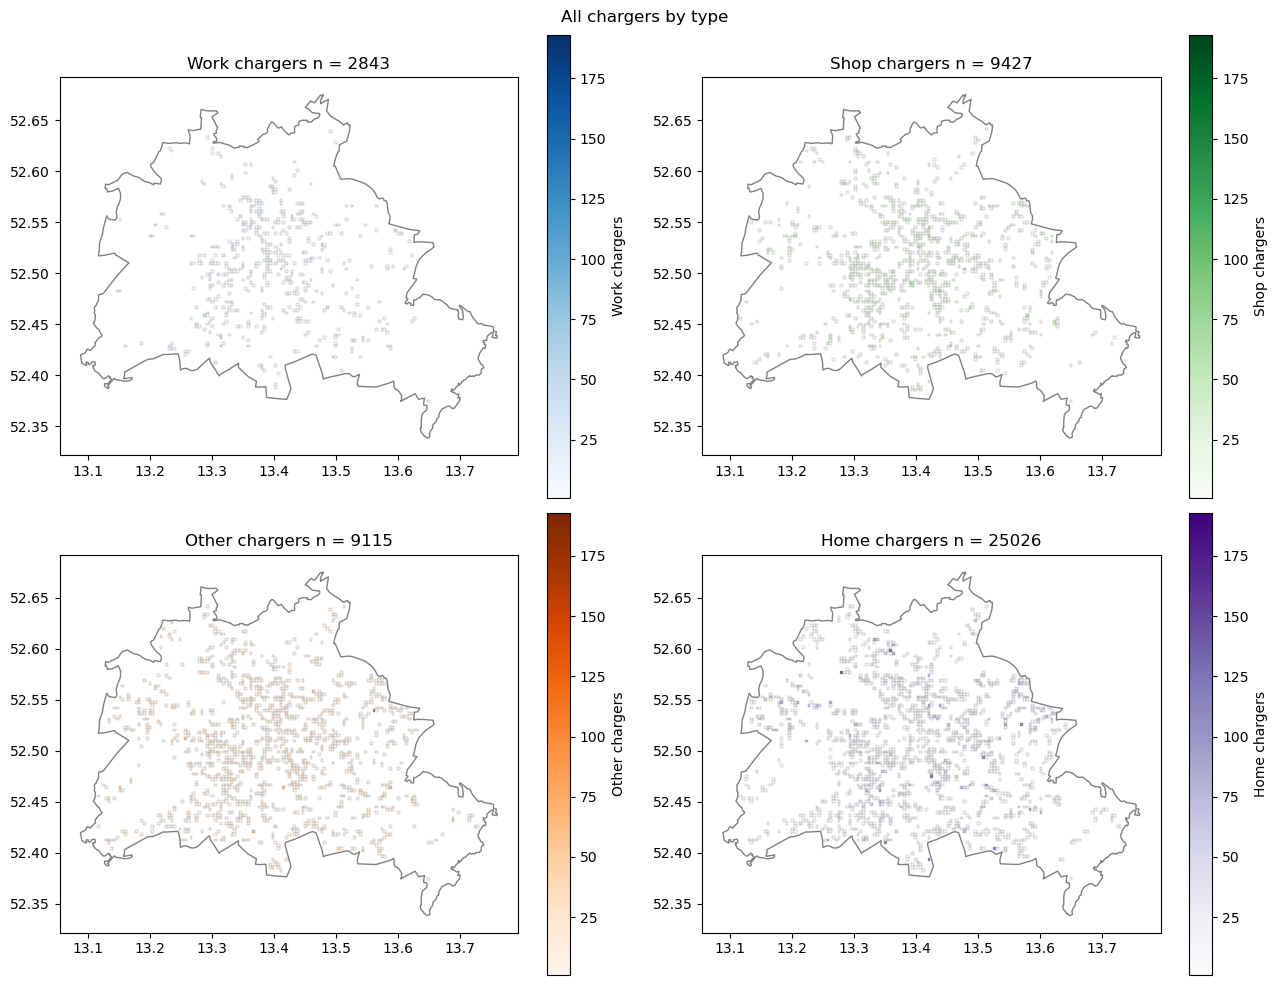

In [130]:
fig, axes = plt.subplots(2, 2, figsize=(13,10))

# Work Chargers
if not charger_types[charger_types['ch_work'] != 0].empty:
    charger_types[charger_types['ch_work'] != 0].plot(
        column='ch_work', cmap='Blues', legend=True, ax=axes[0, 0], edgecolor="grey",
        linewidth=.2, vmax=max_legend, legend_kwds={'label': f'Work chargers'}
    )
    axes[0, 0].set_title(f"Work chargers n = {analysis_df['Count'][0]}")
else:
    axes[0, 0].axis('off')

# Shop Chargers
if not charger_types[charger_types['ch_shop'] != 0].empty:
    charger_types[charger_types['ch_shop'] != 0].plot(
        column='ch_shop', cmap='Greens', legend=True, ax=axes[0, 1], edgecolor="grey",
        linewidth=.2, vmax=max_legend, legend_kwds={'label': f'Shop chargers'}
    )
    axes[0, 1].set_title(f"Shop chargers n = {analysis_df['Count'][1]}")
else:
    axes[0, 1].axis('off')

# Other Chargers
if not charger_types[charger_types['ch_other'] != 0].empty:
    charger_types[charger_types['ch_other'] != 0].plot(
        column='ch_other', cmap='Oranges', legend=True, ax=axes[1, 0], edgecolor="grey",
        linewidth=.2, vmax=max_legend, legend_kwds={'label': f'Other chargers'}
    )
    axes[1, 0].set_title(f"Other chargers n = {analysis_df['Count'][2]}")
else:
    axes[1, 0].axis('off')

# Home Chargers
if not charger_types[charger_types['ch_home'] != 0].empty:
    charger_types[charger_types['ch_home'] != 0].plot(
        column='ch_home', cmap='Purples', legend=True, ax=axes[1, 1], edgecolor="grey",
        linewidth=.2, vmax=max_legend, legend_kwds={'label': f'Home chargers'}
    )
    axes[1, 1].set_title(f"Home chargers n = {analysis_df['Count'][3]}")
else:
    axes[1, 1].axis('off')

# Plot of city boarders on fields with plots
for i, ax in enumerate(axes.flat):
    if ax.get_visible() and not ax.axis() == (0, 1, 0, 1):  # Sicherstellen, dass die Achse Daten enthält
        outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)

plt.suptitle("All chargers by type")
plt.tight_layout()
plt.show()

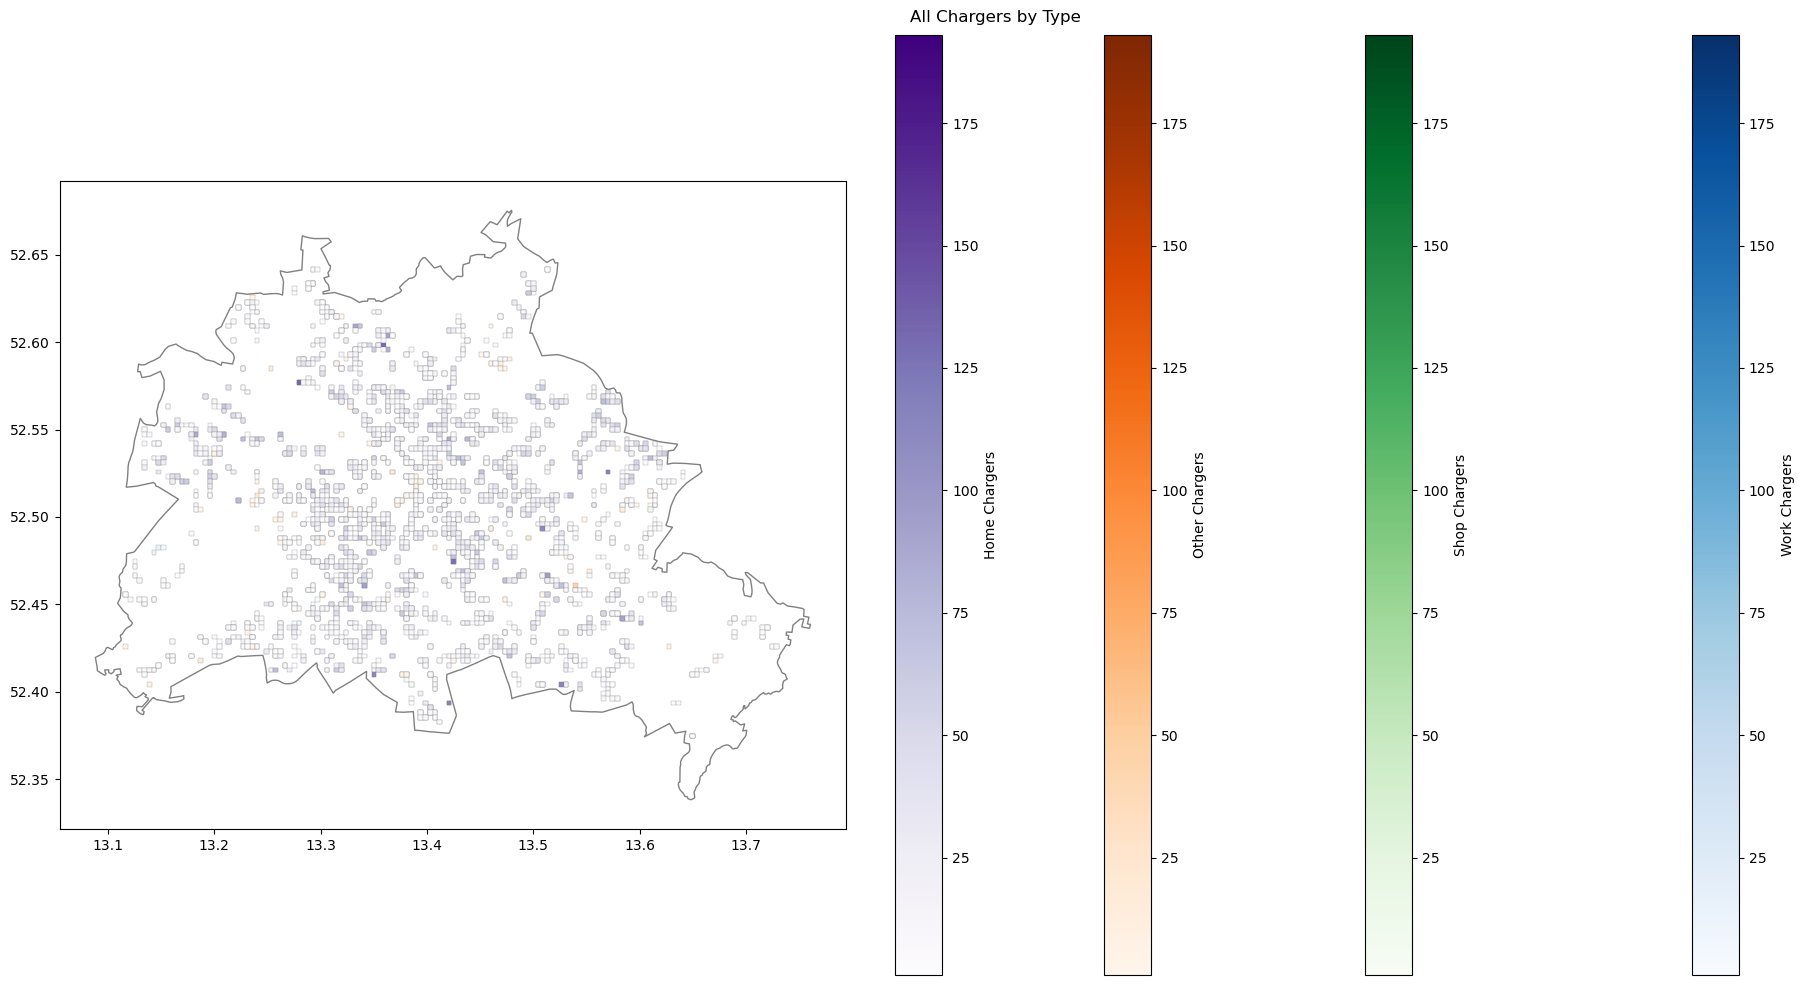

In [131]:
# In this figure all charging types are plotted in one figure. This only useful for some cities, as colors are not recognizable in many cases.

fig, ax = plt.subplots(figsize=(20,10))

charger_types[charger_types['ch_work'] != 0].plot(column='ch_work', cmap='Blues', legend=True, ax=ax, edgecolor="grey", 
                                           linewidth=.2, vmax=max_legend, legend_kwds={'label': f'Work Chargers'})


charger_types[charger_types['ch_shop'] != 0].plot(column='ch_shop', cmap='Greens', legend=True, ax=ax, edgecolor="grey", 
                                           linewidth=.2,vmax=max_legend, legend_kwds={'label': f'Shop Chargers'})


charger_types[charger_types['ch_other'] != 0].plot(column='ch_other', cmap='Oranges', legend=True, ax=ax, edgecolor="grey", 
                                           linewidth=.2,vmax=max_legend, legend_kwds={'label': f'Other Chargers'})


charger_types[charger_types['ch_home'] != 0].plot(column='ch_home', cmap='Purples', legend=True, ax=ax, edgecolor="grey", 
                                           linewidth=.2,vmax=max_legend, legend_kwds={'label': f'Home Chargers'})

outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)

plt.suptitle("All Chargers by Type")
plt.tight_layout()
plt.show()

## Subsets of charging points

If you only want to calculate a subset of charging points, this is done here. Please input the amount below.

The first-placed charging points are selected because they are placed at the locations where demand is highest.

In [134]:
print(f'The amount needs to be lower or equal to {chargers_placed}.')

The amount needs to be lower or equal to 46411.


In [135]:
amount_subset = 20000

In [136]:
#list_placements[:amount_subset]

In [137]:
subset = topsis_result_unweighted.copy()

In [138]:
subset['placements_count'] = 0

for c_point in list_placements[:amount_subset]:
    x, y = c_point 
    subset.loc[(subset['x'] == x) & (subset['y'] == y), 'placements_count'] += 1

In [139]:
print(f'The {subset['placements_count'].sum()} chargers which have been placed first are displayed.')
print(f'They got placed in {subset[subset['placements_count']!=0]['placements_count'].count()} different cells.')

The 20000 chargers which have been placed first are displayed.
They got placed in 647 different cells.


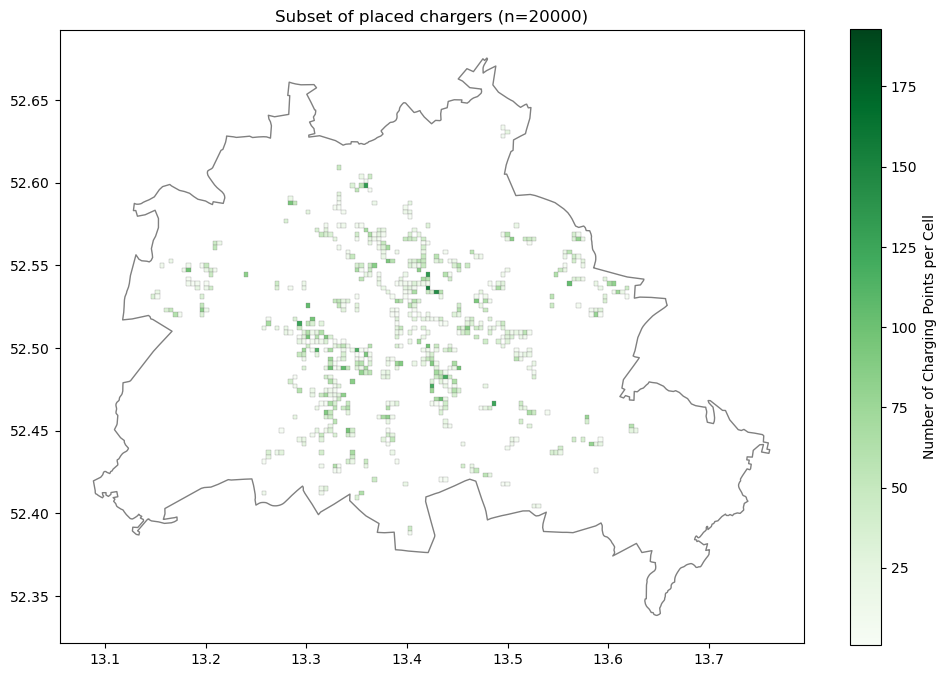

In [140]:
fig, ax = plt.subplots(figsize=(12,8))
subset[subset['placements_count'] != 0].plot(column ='placements_count' , cmap='Greens', edgecolor="grey", 
                    linewidth=.2, legend=True, ax=ax, vmax = max_legend, legend_kwds={'label': 'Number of Charging Points per Cell'})
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title(f"Subset of placed chargers (n={amount_subset})")
plt.show()

## Subsets of districts (only available if district data is imported!)

 This function is suitable for displaying the placed charging points of individual sub-areas of a city, such as districts. However, it must be ensured that the outline data of the sub-areas is integrated. In this case, they were imported under “Other Data”.

 A list of the available districts is displayed below. Please select a district from this list and insert it's name in the cell below as “chosen_district”.

In [143]:
print(districts['Gemeinde_n'])

0                  Reinickendorf
1     Charlottenburg-Wilmersdorf
2               Treptow-Köpenick
3                         Pankow
4                       Neukölln
5                    Lichtenberg
6            Marzahn-Hellersdorf
7                        Spandau
8            Steglitz-Zehlendorf
9                          Mitte
10      Friedrichshain-Kreuzberg
11          Tempelhof-Schöneberg
Name: Gemeinde_n, dtype: object


In [144]:
chosen_district = 'Treptow-Köpenick'

In [145]:
subset_district = results.copy()
district_outline = districts[districts['Gemeinde_n']==chosen_district]


touching_city = subset_district.within(district_outline.unary_union)
data_columns = subset_district.columns[3:]  
subset_district.loc[~touching_city, data_columns] = 0

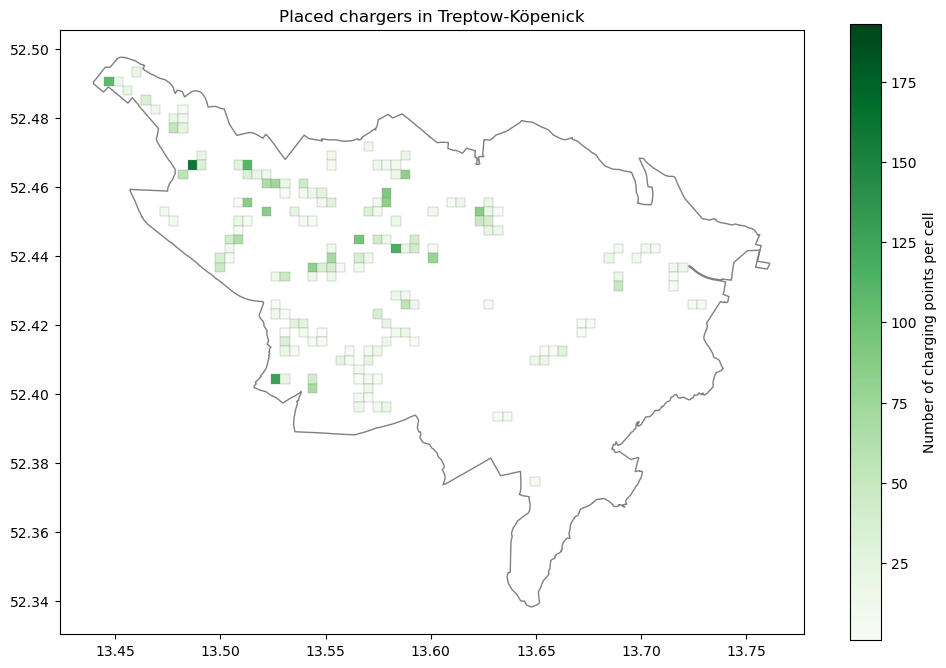

In [146]:
fig, ax = plt.subplots(figsize=(12,8))
subset_district[subset_district['chargers_placed'] != 0].plot(column ='chargers_placed' , cmap='Greens', edgecolor="grey", 
                    linewidth=.2, legend=True, ax=ax, vmax = max_legend, legend_kwds={'label': 'Number of charging points per cell'})
district_outline.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
plt.title(f"Placed chargers in {chosen_district}")
plt.show()

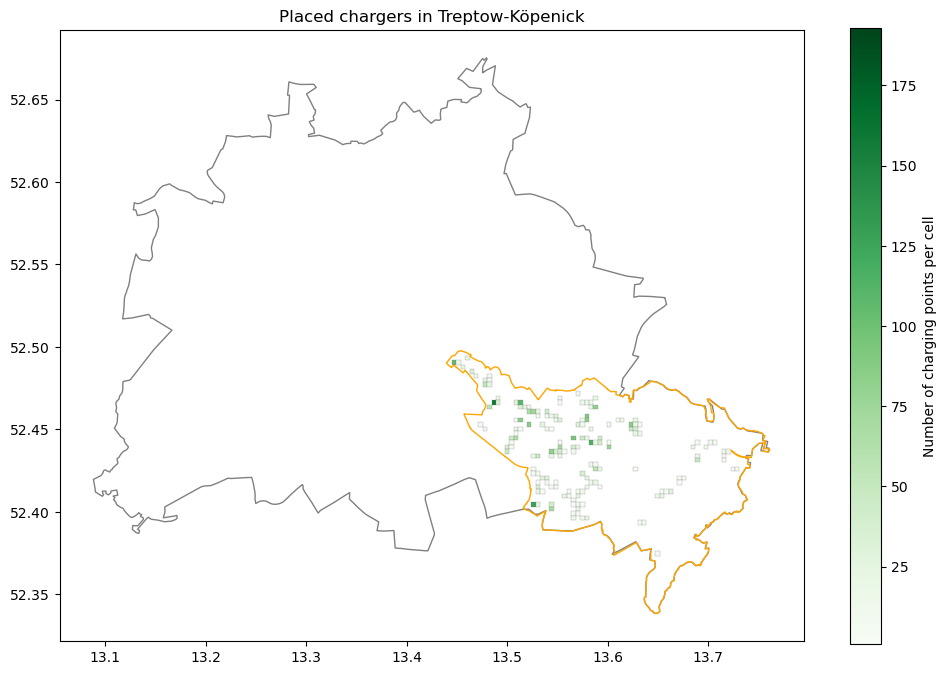

In [147]:
fig, ax = plt.subplots(figsize=(12,8))
subset_district[subset_district['chargers_placed'] != 0].plot(column ='chargers_placed' , cmap='Greens', edgecolor="grey", 
                    linewidth=.2, legend=True, ax=ax, vmax = max_legend, legend_kwds={'label': 'Number of charging points per cell'})
outline_city.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1)
district_outline.plot(ax=ax, facecolor="none", edgecolor="orange", linewidth=1)
plt.title(f"Placed chargers in {chosen_district}")
plt.show()